In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 134

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [26]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [27]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [28]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [31]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [32]:
batch_train = batch_train + batch_val

In [33]:
train_output = train_output[:, 0:pred_num]
train_output.shape

(66175, 134)

In [34]:
val_output = val_output[:, 0:pred_num]
val_output.shape

(28921, 134)

In [35]:
test_output = test_output[:, 0:pred_num]
test_output.shape

(1000, 134)

In [36]:
train_ds = TensorDataset(RNA_s1d1, pro_s1d1)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [37]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [38]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [39]:
PATH = 'No_norm_model_RNA_pro'

In [59]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

        if epoch % 100 == 0:
            model = model.eval()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
#             if val_loss < val_best:
#                 torch.save(model.state_dict(), PATH)
#                 val_best = val_loss
                
            print('Epoch ', epoch, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:', s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss)
            
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 12, figsize = (30, 3))
            for i in range(1):
                ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('s1d1 result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')

                ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d2 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d3 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
                
                ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s2d1 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')

                ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d4 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d5 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
                ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s3d1 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')

                ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d6 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d7 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')
                
                ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s4d1 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')

                ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d8 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d9 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return s1d1_pred.cpu().detach().numpy(), s1d2.cpu().detach().numpy(), s1d3.cpu().detach().numpy(), s2d1.cpu().detach().numpy()

Epoch  0 s1d1:  1.3047638 s1d2:  1.3135449 s1d3:  1.2866043 s2d1: 0.8904128 s2d4: 0.9275968 s2d5: 0.9385307 s3d1: 0.9208998 s3d6: 0.8034119 s3d7: 0.8313433 s4d1: 1.0990627 s4d8: 1.2970951 s4d9: 1.1300478


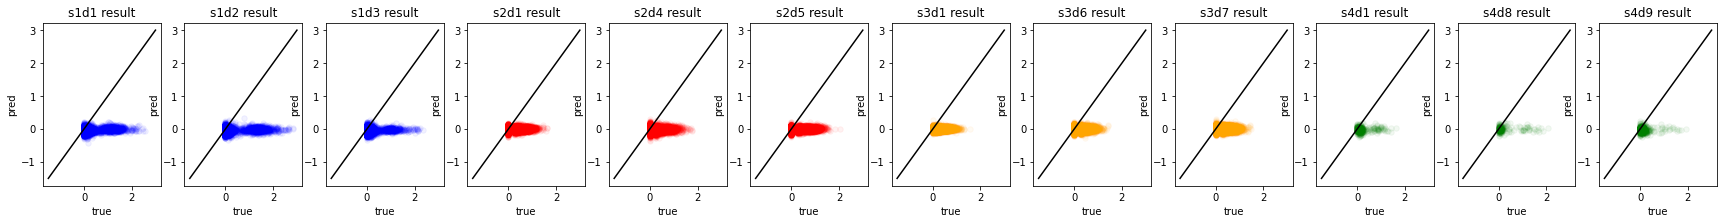

Epoch  100 s1d1:  0.447977 s1d2:  0.563932 s1d3:  0.4909346 s2d1: 0.45573103 s2d4: 0.60581553 s2d5: 0.49532598 s3d1: 0.5485956 s3d6: 0.57541734 s3d7: 0.52601904 s4d1: 0.5461831 s4d8: 0.5810722 s4d9: 0.5806995
Epoch  200 s1d1:  0.41597283 s1d2:  0.5223386 s1d3:  0.4647457 s2d1: 0.44699362 s2d4: 0.6010669 s2d5: 0.4754707 s3d1: 0.5397846 s3d6: 0.57189476 s3d7: 0.519881 s4d1: 0.5237951 s4d8: 0.5491836 s4d9: 0.5606467
Epoch  300 s1d1:  0.39465293 s1d2:  0.49968854 s1d3:  0.44709232 s2d1: 0.44428986 s2d4: 0.6015524 s2d5: 0.467272 s3d1: 0.53153884 s3d6: 0.57405424 s3d7: 0.5209512 s4d1: 0.5156644 s4d8: 0.53423595 s4d9: 0.55347544
Epoch  400 s1d1:  0.37792766 s1d2:  0.48576033 s1d3:  0.43287456 s2d1: 0.44296426 s2d4: 0.60327303 s2d5: 0.46302226 s3d1: 0.5253118 s3d6: 0.57733583 s3d7: 0.52328897 s4d1: 0.5122781 s4d8: 0.5251889 s4d9: 0.55122167
Epoch  500 s1d1:  0.36438498 s1d2:  0.47497728 s1d3:  0.42201087 s2d1: 0.44177043 s2d4: 0.60382026 s2d5: 0.45934758 s3d1: 0.5212363 s3d6: 0.5796513 s3d7: 0

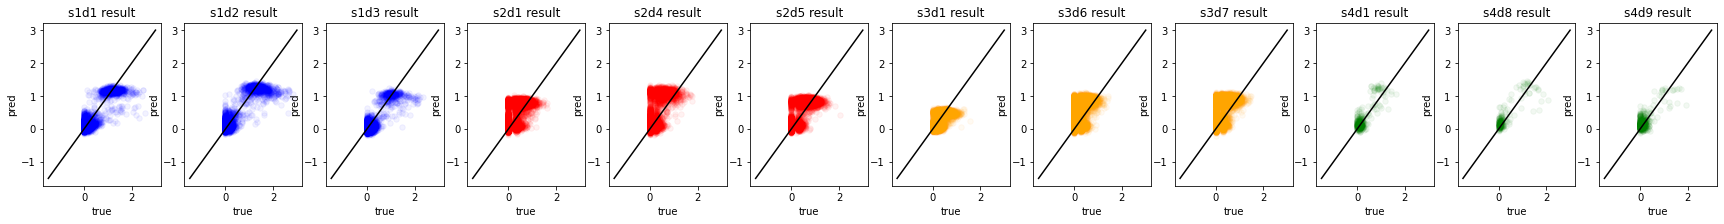

Epoch  1100 s1d1:  0.32082966 s1d2:  0.44646278 s1d3:  0.39404693 s2d1: 0.43628627 s2d4: 0.6043102 s2d5: 0.4471435 s3d1: 0.5119141 s3d6: 0.5871806 s3d7: 0.52617455 s4d1: 0.5066439 s4d8: 0.49953604 s4d9: 0.5520502
Epoch  1200 s1d1:  0.31639007 s1d2:  0.4444127 s1d3:  0.39183015 s2d1: 0.435914 s2d4: 0.60464734 s2d5: 0.44649848 s3d1: 0.51133317 s3d6: 0.58812714 s3d7: 0.5264231 s4d1: 0.50659615 s4d8: 0.49791667 s4d9: 0.55270845
Epoch  1300 s1d1:  0.3122443 s1d2:  0.44263726 s1d3:  0.38992545 s2d1: 0.43551502 s2d4: 0.60497785 s2d5: 0.4459231 s3d1: 0.5108085 s3d6: 0.5889249 s3d7: 0.52667093 s4d1: 0.50669956 s4d8: 0.49656808 s4d9: 0.5533981
Epoch  1400 s1d1:  0.30837455 s1d2:  0.44080642 s1d3:  0.38834298 s2d1: 0.43510124 s2d4: 0.6050108 s2d5: 0.44537196 s3d1: 0.51060766 s3d6: 0.58956313 s3d7: 0.52687734 s4d1: 0.50651073 s4d8: 0.4949821 s4d9: 0.55350447
Epoch  1500 s1d1:  0.30471984 s1d2:  0.43912748 s1d3:  0.3870312 s2d1: 0.43459034 s2d4: 0.6046286 s2d5: 0.4447316 s3d1: 0.51037246 s3d6: 0.58

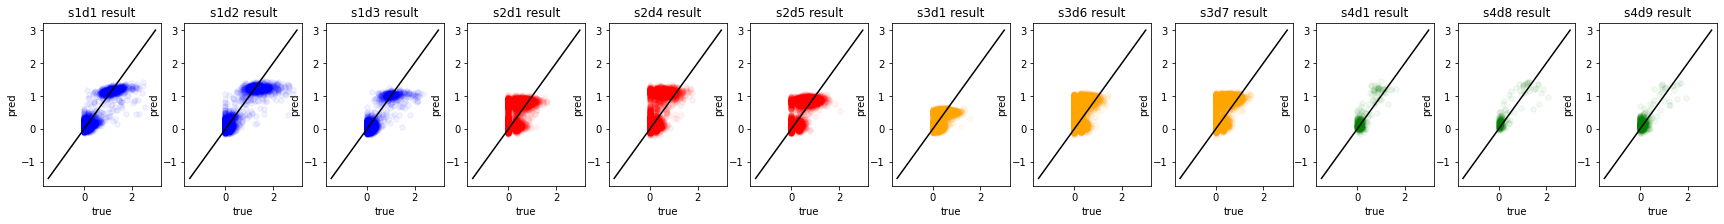

Epoch  2100 s1d1:  0.28582394 s1d2:  0.43279997 s1d3:  0.38050422 s2d1: 0.43397 s2d4: 0.6062406 s2d5: 0.44365534 s3d1: 0.50939935 s3d6: 0.5932056 s3d7: 0.52835554 s4d1: 0.5060862 s4d8: 0.4880265 s4d9: 0.5553162
Epoch  2200 s1d1:  0.28308454 s1d2:  0.43187642 s1d3:  0.37984717 s2d1: 0.4336177 s2d4: 0.6062367 s2d5: 0.44330242 s3d1: 0.5092859 s3d6: 0.59331334 s3d7: 0.5285008 s4d1: 0.5057124 s4d8: 0.48728722 s4d9: 0.555106
Epoch  2300 s1d1:  0.28041747 s1d2:  0.4311509 s1d3:  0.3791543 s2d1: 0.43374014 s2d4: 0.6064072 s2d5: 0.4434174 s3d1: 0.5092988 s3d6: 0.5938988 s3d7: 0.52876246 s4d1: 0.50592244 s4d8: 0.48662877 s4d9: 0.55561125
Epoch  2400 s1d1:  0.2778562 s1d2:  0.43031007 s1d3:  0.37869892 s2d1: 0.43348587 s2d4: 0.60609436 s2d5: 0.4431464 s3d1: 0.50953394 s3d6: 0.593901 s3d7: 0.52847713 s4d1: 0.50565916 s4d8: 0.48589912 s4d9: 0.55555147
Epoch  2500 s1d1:  0.2753477 s1d2:  0.42973676 s1d3:  0.378121 s2d1: 0.43361565 s2d4: 0.60637987 s2d5: 0.44333634 s3d1: 0.5093681 s3d6: 0.59452367 s3

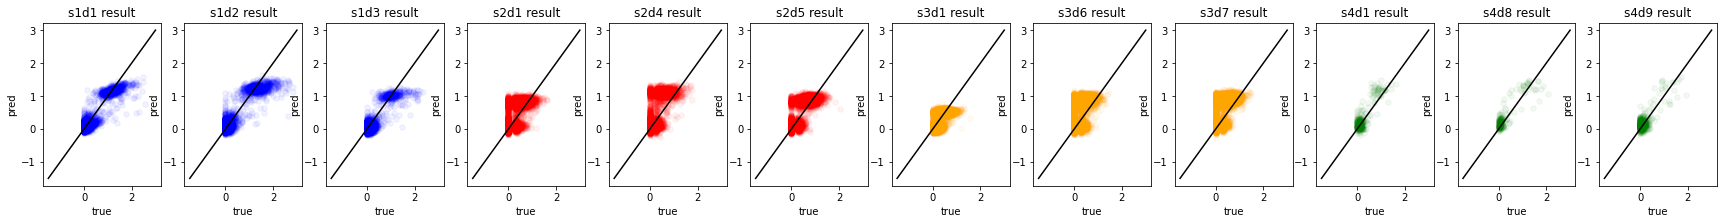

Epoch  3100 s1d1:  0.26154235 s1d2:  0.4273916 s1d3:  0.37567893 s2d1: 0.43383586 s2d4: 0.60852164 s2d5: 0.44373247 s3d1: 0.5090693 s3d6: 0.5970665 s3d7: 0.53093666 s4d1: 0.5073146 s4d8: 0.48445162 s4d9: 0.558524
Epoch  3200 s1d1:  0.2594077 s1d2:  0.4271925 s1d3:  0.37517998 s2d1: 0.4341065 s2d4: 0.6092863 s2d5: 0.44406164 s3d1: 0.50900036 s3d6: 0.5977802 s3d7: 0.53136235 s4d1: 0.50805986 s4d8: 0.48491648 s4d9: 0.55975163
Epoch  3300 s1d1:  0.25736737 s1d2:  0.42669657 s1d3:  0.37510616 s2d1: 0.4339102 s2d4: 0.6088228 s2d5: 0.44388062 s3d1: 0.5090902 s3d6: 0.59769726 s3d7: 0.5312468 s4d1: 0.50774074 s4d8: 0.48445496 s4d9: 0.5594599
Epoch  3400 s1d1:  0.2553233 s1d2:  0.42661887 s1d3:  0.37481782 s2d1: 0.4342275 s2d4: 0.6097125 s2d5: 0.44426277 s3d1: 0.50915927 s3d6: 0.5985274 s3d7: 0.5319387 s4d1: 0.5085722 s4d8: 0.4847608 s4d9: 0.5604246
Epoch  3500 s1d1:  0.25333744 s1d2:  0.4261279 s1d3:  0.37468493 s2d1: 0.4341239 s2d4: 0.6097838 s2d5: 0.44422624 s3d1: 0.50907075 s3d6: 0.5986944 s

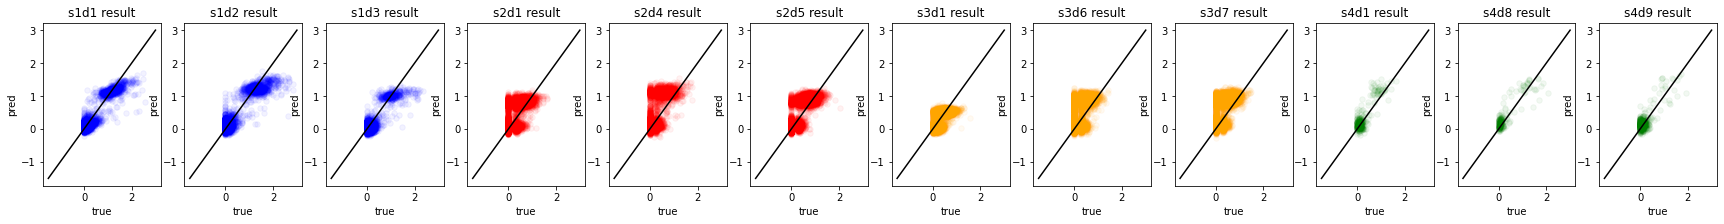

Epoch  4100 s1d1:  0.24217759 s1d2:  0.4253271 s1d3:  0.374013 s2d1: 0.43450493 s2d4: 0.6115863 s2d5: 0.44504562 s3d1: 0.50883895 s3d6: 0.60061324 s3d7: 0.5336838 s4d1: 0.51004434 s4d8: 0.4846722 s4d9: 0.5628583
Epoch  4200 s1d1:  0.24046008 s1d2:  0.42520604 s1d3:  0.3740911 s2d1: 0.4343988 s2d4: 0.61127424 s2d5: 0.4451106 s3d1: 0.50899404 s3d6: 0.6007649 s3d7: 0.5338031 s4d1: 0.5101567 s4d8: 0.4846437 s4d9: 0.56300545
Epoch  4300 s1d1:  0.23875341 s1d2:  0.42478442 s1d3:  0.37418434 s2d1: 0.43430597 s2d4: 0.61135733 s2d5: 0.44504082 s3d1: 0.50910014 s3d6: 0.60075444 s3d7: 0.53381854 s4d1: 0.50996786 s4d8: 0.48434877 s4d9: 0.5628222
Epoch  4400 s1d1:  0.23707905 s1d2:  0.42454892 s1d3:  0.37428805 s2d1: 0.43393552 s2d4: 0.61103237 s2d5: 0.44486573 s3d1: 0.5092222 s3d6: 0.6004411 s3d7: 0.53363967 s4d1: 0.5097757 s4d8: 0.48402652 s4d9: 0.5625284
Epoch  4500 s1d1:  0.23543745 s1d2:  0.4245639 s1d3:  0.37426007 s2d1: 0.43426132 s2d4: 0.6113275 s2d5: 0.445257 s3d1: 0.50928026 s3d6: 0.60107

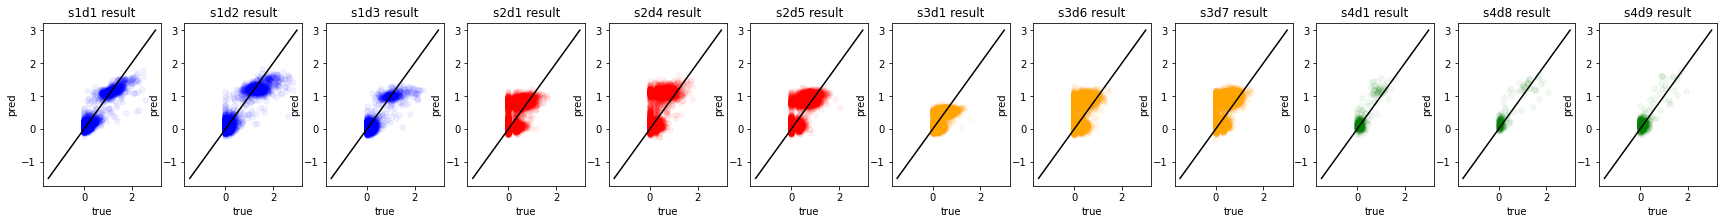

Epoch  5100 s1d1:  0.22596706 s1d2:  0.42472073 s1d3:  0.3741403 s2d1: 0.4349628 s2d4: 0.61358005 s2d5: 0.446405 s3d1: 0.509088 s3d6: 0.6030928 s3d7: 0.53585374 s4d1: 0.51277673 s4d8: 0.4858818 s4d9: 0.56626856
Epoch  5200 s1d1:  0.22442783 s1d2:  0.42514926 s1d3:  0.37358093 s2d1: 0.43574366 s2d4: 0.6154525 s2d5: 0.44704863 s3d1: 0.5086267 s3d6: 0.60431355 s3d7: 0.5368998 s4d1: 0.5143101 s4d8: 0.48722556 s4d9: 0.5682072
Epoch  5300 s1d1:  0.22300121 s1d2:  0.42456058 s1d3:  0.3742002 s2d1: 0.4350413 s2d4: 0.6140647 s2d5: 0.4465188 s3d1: 0.509093 s3d6: 0.60337245 s3d7: 0.5359248 s4d1: 0.5132609 s4d8: 0.48611102 s4d9: 0.5670023
Epoch  5400 s1d1:  0.22158541 s1d2:  0.4244652 s1d3:  0.3744224 s2d1: 0.4348589 s2d4: 0.61363095 s2d5: 0.4465018 s3d1: 0.5092421 s3d6: 0.60328734 s3d7: 0.53590703 s4d1: 0.51307106 s4d8: 0.48583078 s4d9: 0.5666837
Epoch  5500 s1d1:  0.22015627 s1d2:  0.42457762 s1d3:  0.37447116 s2d1: 0.43504062 s2d4: 0.6139316 s2d5: 0.44672987 s3d1: 0.509351 s3d6: 0.6036093 s3d7:

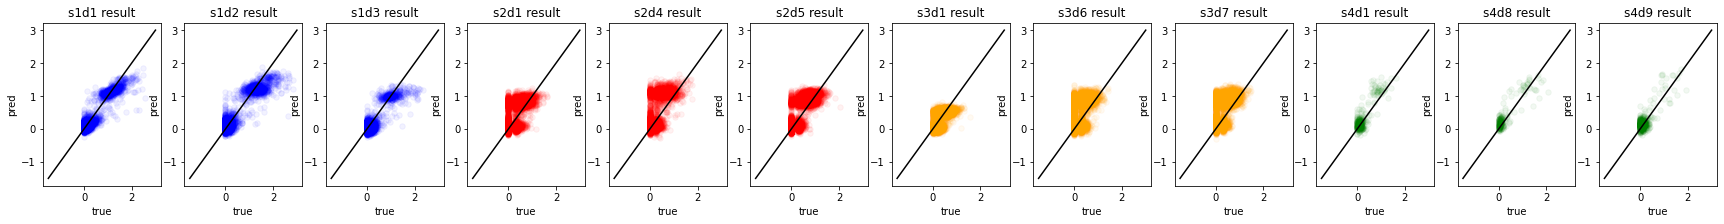

Epoch  6100 s1d1:  0.21198194 s1d2:  0.42478532 s1d3:  0.37497205 s2d1: 0.4355319 s2d4: 0.6158107 s2d5: 0.44754517 s3d1: 0.5093144 s3d6: 0.60515547 s3d7: 0.53773046 s4d1: 0.51544964 s4d8: 0.4877161 s4d9: 0.5694782
Epoch  6200 s1d1:  0.21069992 s1d2:  0.42476445 s1d3:  0.37496287 s2d1: 0.43556547 s2d4: 0.6154589 s2d5: 0.44762975 s3d1: 0.50935733 s3d6: 0.6050782 s3d7: 0.537519 s4d1: 0.51555455 s4d8: 0.48764387 s4d9: 0.56959116
Epoch  6300 s1d1:  0.2093615 s1d2:  0.42538905 s1d3:  0.37476176 s2d1: 0.43602312 s2d4: 0.6168809 s2d5: 0.44814005 s3d1: 0.5088932 s3d6: 0.6060707 s3d7: 0.5386657 s4d1: 0.5167448 s4d8: 0.48886517 s4d9: 0.5709292
Epoch  6400 s1d1:  0.20818575 s1d2:  0.42480862 s1d3:  0.37559405 s2d1: 0.4353398 s2d4: 0.61532265 s2d5: 0.44765002 s3d1: 0.5095801 s3d6: 0.60505426 s3d7: 0.5376482 s4d1: 0.5155442 s4d8: 0.48773775 s4d9: 0.5695265
Epoch  6500 s1d1:  0.20682037 s1d2:  0.42581314 s1d3:  0.37477565 s2d1: 0.43650484 s2d4: 0.61797667 s2d5: 0.4486757 s3d1: 0.5089334 s3d6: 0.60694

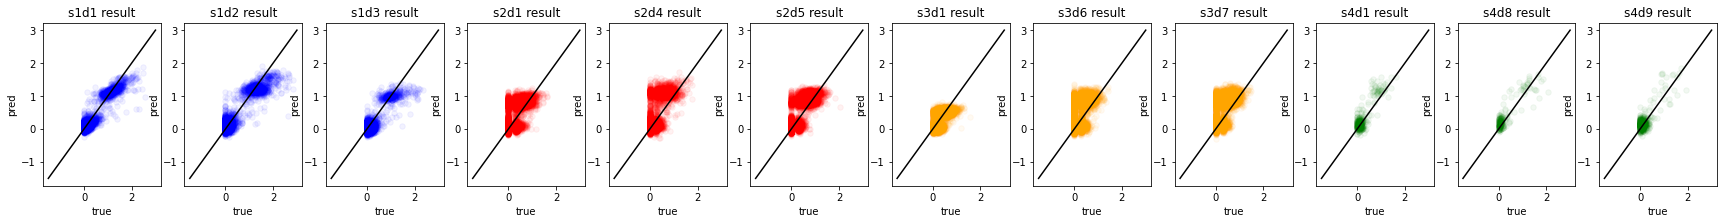

Epoch  7100 s1d1:  0.1996749 s1d2:  0.42607412 s1d3:  0.37568036 s2d1: 0.43668818 s2d4: 0.6183664 s2d5: 0.44924664 s3d1: 0.5092614 s3d6: 0.6076372 s3d7: 0.53995246 s4d1: 0.51893663 s4d8: 0.49038744 s4d9: 0.5734271
Epoch  7200 s1d1:  0.1985144 s1d2:  0.4262628 s1d3:  0.37572172 s2d1: 0.43691415 s2d4: 0.61898243 s2d5: 0.44948772 s3d1: 0.50926405 s3d6: 0.6080382 s3d7: 0.54033494 s4d1: 0.5194192 s4d8: 0.49096027 s4d9: 0.57412523
Epoch  7300 s1d1:  0.19739039 s1d2:  0.42634574 s1d3:  0.37576744 s2d1: 0.4369449 s2d4: 0.61900693 s2d5: 0.44959906 s3d1: 0.50921774 s3d6: 0.60812527 s3d7: 0.54045135 s4d1: 0.519614 s4d8: 0.4911984 s4d9: 0.57435554
Epoch  7400 s1d1:  0.19627585 s1d2:  0.42640054 s1d3:  0.3759053 s2d1: 0.43685278 s2d4: 0.61881983 s2d5: 0.44961497 s3d1: 0.5093448 s3d6: 0.6080033 s3d7: 0.5402891 s4d1: 0.51986754 s4d8: 0.49138936 s4d9: 0.5744902
Epoch  7500 s1d1:  0.19516315 s1d2:  0.42654052 s1d3:  0.3761681 s2d1: 0.43699884 s2d4: 0.6192658 s2d5: 0.4497856 s3d1: 0.5094045 s3d6: 0.6083

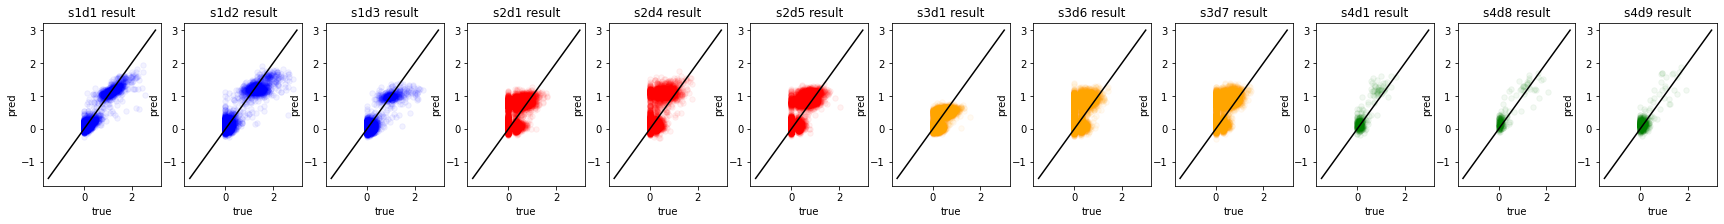

Epoch  8100 s1d1:  0.18885191 s1d2:  0.4267163 s1d3:  0.37712967 s2d1: 0.4370635 s2d4: 0.6193161 s2d5: 0.4502184 s3d1: 0.50987744 s3d6: 0.6086895 s3d7: 0.5409088 s4d1: 0.5208666 s4d8: 0.4920993 s4d9: 0.5755699
Epoch  8200 s1d1:  0.18781406 s1d2:  0.42697623 s1d3:  0.37731048 s2d1: 0.43723795 s2d4: 0.61995494 s2d5: 0.45034868 s3d1: 0.50975126 s3d6: 0.6091502 s3d7: 0.54152364 s4d1: 0.5212175 s4d8: 0.49251753 s4d9: 0.57588524
Epoch  8300 s1d1:  0.18675128 s1d2:  0.427403 s1d3:  0.3771202 s2d1: 0.43749377 s2d4: 0.620654 s2d5: 0.45070833 s3d1: 0.5095872 s3d6: 0.60959303 s3d7: 0.54186887 s4d1: 0.52220243 s4d8: 0.49340358 s4d9: 0.5770036
Epoch  8400 s1d1:  0.18577522 s1d2:  0.42741695 s1d3:  0.37727782 s2d1: 0.43762738 s2d4: 0.6206279 s2d5: 0.45090273 s3d1: 0.50972635 s3d6: 0.60971725 s3d7: 0.54192305 s4d1: 0.52230185 s4d8: 0.49337482 s4d9: 0.57718325
Epoch  8500 s1d1:  0.18481708 s1d2:  0.42726716 s1d3:  0.37767792 s2d1: 0.43722093 s2d4: 0.62015885 s2d5: 0.45058367 s3d1: 0.5098504 s3d6: 0.60

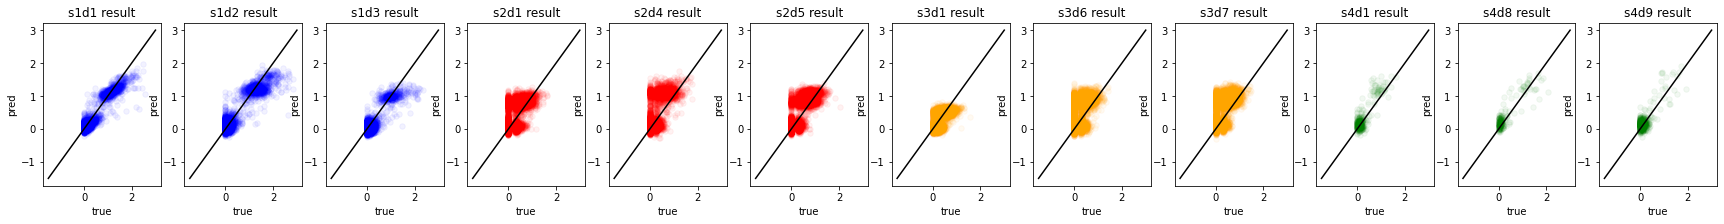

Epoch  9100 s1d1:  0.17911486 s1d2:  0.42802072 s1d3:  0.37853387 s2d1: 0.43773526 s2d4: 0.6213553 s2d5: 0.45131314 s3d1: 0.50984085 s3d6: 0.61036074 s3d7: 0.54276174 s4d1: 0.5232014 s4d8: 0.49446762 s4d9: 0.5781544
Epoch  9200 s1d1:  0.17818052 s1d2:  0.4281914 s1d3:  0.37842664 s2d1: 0.43787587 s2d4: 0.6216357 s2d5: 0.4514825 s3d1: 0.5098144 s3d6: 0.6104564 s3d7: 0.5427429 s4d1: 0.5236764 s4d8: 0.49491072 s4d9: 0.5787587
Epoch  9300 s1d1:  0.17726475 s1d2:  0.42839968 s1d3:  0.37856546 s2d1: 0.4380959 s2d4: 0.6220322 s2d5: 0.45178685 s3d1: 0.51008713 s3d6: 0.6109282 s3d7: 0.5432004 s4d1: 0.52421063 s4d8: 0.49525717 s4d9: 0.57928336
Epoch  9400 s1d1:  0.17633079 s1d2:  0.4288686 s1d3:  0.37846658 s2d1: 0.4384221 s2d4: 0.622902 s2d5: 0.45208114 s3d1: 0.5097426 s3d6: 0.6115208 s3d7: 0.54393655 s4d1: 0.52489275 s4d8: 0.49607313 s4d9: 0.5800935
Epoch  9500 s1d1:  0.17549874 s1d2:  0.42848554 s1d3:  0.37877882 s2d1: 0.43800843 s2d4: 0.62190515 s2d5: 0.45177814 s3d1: 0.5100698 s3d6: 0.61072

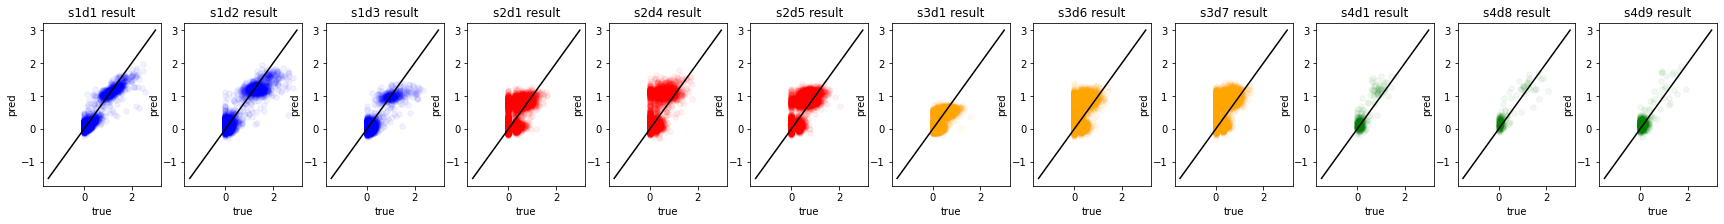

Epoch  10100 s1d1:  0.17033605 s1d2:  0.42943883 s1d3:  0.37944216 s2d1: 0.43867424 s2d4: 0.62351 s2d5: 0.4525575 s3d1: 0.50995827 s3d6: 0.61208427 s3d7: 0.5443706 s4d1: 0.5261011 s4d8: 0.49728656 s4d9: 0.5814733
Epoch  10200 s1d1:  0.16947815 s1d2:  0.42973357 s1d3:  0.3793489 s2d1: 0.43890008 s2d4: 0.6239106 s2d5: 0.45288312 s3d1: 0.5099117 s3d6: 0.61241865 s3d7: 0.54470295 s4d1: 0.52666575 s4d8: 0.49765578 s4d9: 0.58198714
Epoch  10300 s1d1:  0.16868046 s1d2:  0.42995417 s1d3:  0.37952447 s2d1: 0.43899825 s2d4: 0.6239881 s2d5: 0.4530438 s3d1: 0.50995904 s3d6: 0.6125722 s3d7: 0.54483765 s4d1: 0.5268285 s4d8: 0.49795836 s4d9: 0.5823771
Epoch  10400 s1d1:  0.1678571 s1d2:  0.42999232 s1d3:  0.37968346 s2d1: 0.43892196 s2d4: 0.62409383 s2d5: 0.4529213 s3d1: 0.5099699 s3d6: 0.61253744 s3d7: 0.54483557 s4d1: 0.52683735 s4d8: 0.49805072 s4d9: 0.58230525
Epoch  10500 s1d1:  0.16703324 s1d2:  0.4301332 s1d3:  0.3796218 s2d1: 0.43915227 s2d4: 0.6246141 s2d5: 0.45317754 s3d1: 0.5098454 s3d6: 0

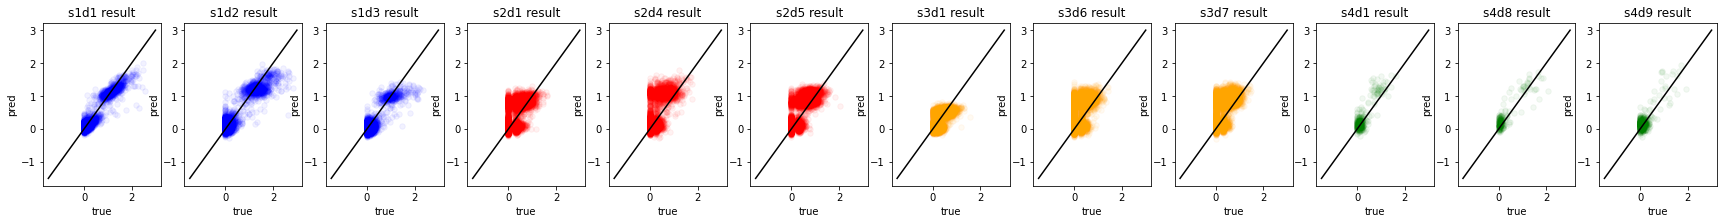

Epoch  11100 s1d1:  0.16239382 s1d2:  0.43073756 s1d3:  0.3804641 s2d1: 0.43941486 s2d4: 0.62512594 s2d5: 0.45371878 s3d1: 0.51006204 s3d6: 0.6133925 s3d7: 0.54567176 s4d1: 0.52845335 s4d8: 0.49944496 s4d9: 0.58398813
Epoch  11200 s1d1:  0.1616416 s1d2:  0.4309305 s1d3:  0.38053674 s2d1: 0.4395396 s2d4: 0.6254264 s2d5: 0.45393145 s3d1: 0.50998765 s3d6: 0.6136272 s3d7: 0.5459571 s4d1: 0.5288227 s4d8: 0.49972665 s4d9: 0.58437186
Epoch  11300 s1d1:  0.16093539 s1d2:  0.43089634 s1d3:  0.3808139 s2d1: 0.43936542 s2d4: 0.625027 s2d5: 0.45376065 s3d1: 0.51015824 s3d6: 0.61333704 s3d7: 0.54566574 s4d1: 0.5285735 s4d8: 0.49972376 s4d9: 0.584241
Epoch  11400 s1d1:  0.16016592 s1d2:  0.4311416 s1d3:  0.38080692 s2d1: 0.43944457 s2d4: 0.62567043 s2d5: 0.45386192 s3d1: 0.5099916 s3d6: 0.6135898 s3d7: 0.5459558 s4d1: 0.52912545 s4d8: 0.5001918 s4d9: 0.5847724
Epoch  11500 s1d1:  0.15948044 s1d2:  0.43117166 s1d3:  0.38113663 s2d1: 0.43936926 s2d4: 0.6252768 s2d5: 0.453901 s3d1: 0.51015204 s3d6: 0.6

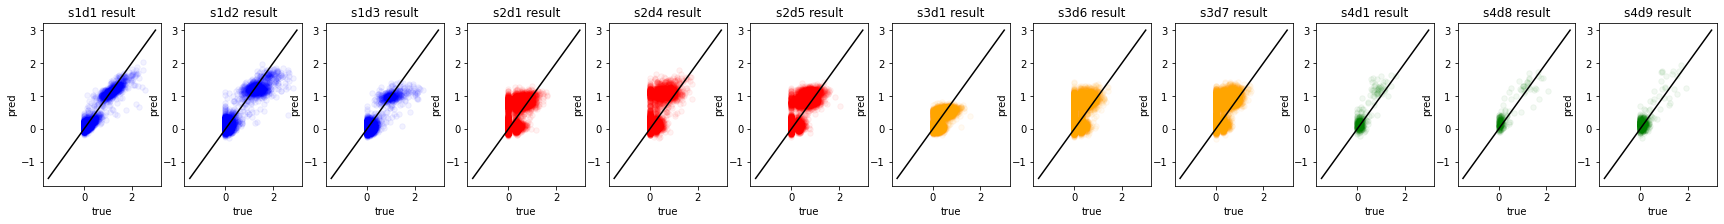

Epoch  12100 s1d1:  0.1552126 s1d2:  0.43204102 s1d3:  0.381634 s2d1: 0.44001755 s2d4: 0.6266176 s2d5: 0.45476344 s3d1: 0.5099443 s3d6: 0.6145809 s3d7: 0.54710776 s4d1: 0.53053355 s4d8: 0.50164795 s4d9: 0.5862615
Epoch  12200 s1d1:  0.15462245 s1d2:  0.43162012 s1d3:  0.38203514 s2d1: 0.43962434 s2d4: 0.6256912 s2d5: 0.45445132 s3d1: 0.51030236 s3d6: 0.61410475 s3d7: 0.54658884 s4d1: 0.52984405 s4d8: 0.50098914 s4d9: 0.5855084
Epoch  12300 s1d1:  0.15389223 s1d2:  0.43206763 s1d3:  0.38196462 s2d1: 0.43973938 s2d4: 0.62630403 s2d5: 0.45454577 s3d1: 0.51016504 s3d6: 0.61436623 s3d7: 0.5468448 s4d1: 0.5303777 s4d8: 0.50162876 s4d9: 0.5861259
Epoch  12400 s1d1:  0.15327063 s1d2:  0.43181014 s1d3:  0.3822408 s2d1: 0.43962905 s2d4: 0.62586933 s2d5: 0.45444846 s3d1: 0.51020646 s3d6: 0.614103 s3d7: 0.54662323 s4d1: 0.5299374 s4d8: 0.5013565 s4d9: 0.58582056
Epoch  12500 s1d1:  0.1525638 s1d2:  0.43214276 s1d3:  0.38224742 s2d1: 0.43987536 s2d4: 0.6266134 s2d5: 0.45465735 s3d1: 0.51021063 s3d6

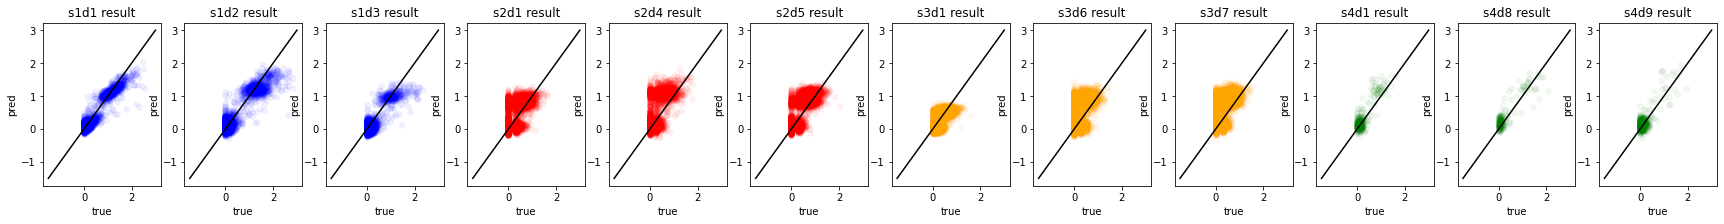

Epoch  13100 s1d1:  0.14870264 s1d2:  0.4329152 s1d3:  0.38286814 s2d1: 0.4400678 s2d4: 0.62741035 s2d5: 0.45511898 s3d1: 0.5102983 s3d6: 0.61515474 s3d7: 0.5477684 s4d1: 0.5316853 s4d8: 0.5030797 s4d9: 0.58752894
Epoch  13200 s1d1:  0.14810805 s1d2:  0.4328091 s1d3:  0.38305488 s2d1: 0.4399421 s2d4: 0.6269741 s2d5: 0.45502892 s3d1: 0.510341 s3d6: 0.61482805 s3d7: 0.54725575 s4d1: 0.5316121 s4d8: 0.5030311 s4d9: 0.58756196
Epoch  13300 s1d1:  0.14742763 s1d2:  0.4332287 s1d3:  0.38288087 s2d1: 0.44030622 s2d4: 0.6277106 s2d5: 0.45546177 s3d1: 0.5101485 s3d6: 0.61545527 s3d7: 0.54792285 s4d1: 0.5323626 s4d8: 0.50363415 s4d9: 0.5882995
Epoch  13400 s1d1:  0.14682598 s1d2:  0.43324944 s1d3:  0.38303137 s2d1: 0.44041684 s2d4: 0.627888 s2d5: 0.45555732 s3d1: 0.51009667 s3d6: 0.6157013 s3d7: 0.5482237 s4d1: 0.53245443 s4d8: 0.5038086 s4d9: 0.5883991
Epoch  13500 s1d1:  0.14615454 s1d2:  0.43376464 s1d3:  0.38283125 s2d1: 0.4409627 s2d4: 0.62901264 s2d5: 0.45610204 s3d1: 0.51014674 s3d6: 0.61

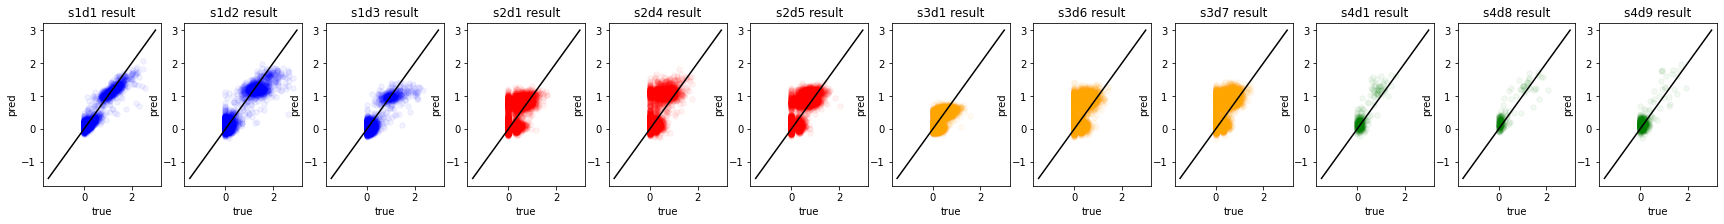

Epoch  14100 s1d1:  0.14266965 s1d2:  0.43415207 s1d3:  0.38372025 s2d1: 0.44076803 s2d4: 0.62886775 s2d5: 0.4561431 s3d1: 0.51023936 s3d6: 0.61642367 s3d7: 0.548989 s4d1: 0.5338033 s4d8: 0.5051632 s4d9: 0.5898964
Epoch  14200 s1d1:  0.14206305 s1d2:  0.43442678 s1d3:  0.38363877 s2d1: 0.44103545 s2d4: 0.62943196 s2d5: 0.45641854 s3d1: 0.5100781 s3d6: 0.61683995 s3d7: 0.5493814 s4d1: 0.5343837 s4d8: 0.5055741 s4d9: 0.5904176
Epoch  14300 s1d1:  0.14147872 s1d2:  0.43469256 s1d3:  0.38361156 s2d1: 0.44119915 s2d4: 0.62976944 s2d5: 0.45663732 s3d1: 0.5101127 s3d6: 0.6170547 s3d7: 0.5494038 s4d1: 0.53509474 s4d8: 0.5062153 s4d9: 0.59117806
Epoch  14400 s1d1:  0.14094502 s1d2:  0.43470943 s1d3:  0.3838063 s2d1: 0.44103307 s2d4: 0.6294476 s2d5: 0.45658135 s3d1: 0.51009315 s3d6: 0.6169648 s3d7: 0.54950607 s4d1: 0.5347603 s4d8: 0.50592947 s4d9: 0.5907009
Epoch  14500 s1d1:  0.14041838 s1d2:  0.434487 s1d3:  0.38403374 s2d1: 0.44074696 s2d4: 0.62901855 s2d5: 0.45625755 s3d1: 0.5101173 s3d6: 0.

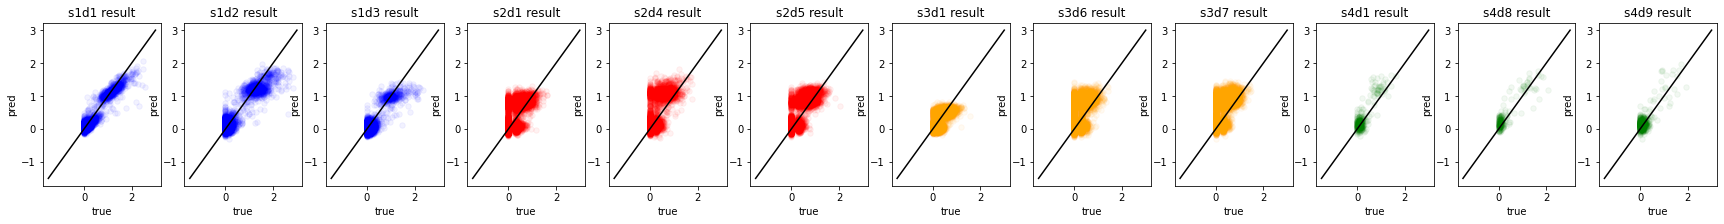

Epoch  15100 s1d1:  0.13710421 s1d2:  0.43545362 s1d3:  0.38431776 s2d1: 0.44110787 s2d4: 0.63072646 s2d5: 0.45682764 s3d1: 0.5095347 s3d6: 0.61728376 s3d7: 0.55012804 s4d1: 0.53569645 s4d8: 0.5076873 s4d9: 0.59207267
Epoch  15200 s1d1:  0.13659462 s1d2:  0.43535405 s1d3:  0.38459373 s2d1: 0.44124237 s2d4: 0.6303648 s2d5: 0.45690954 s3d1: 0.50991017 s3d6: 0.6173452 s3d7: 0.55008566 s4d1: 0.53570634 s4d8: 0.5072668 s4d9: 0.5918441
Epoch  15300 s1d1:  0.1360528 s1d2:  0.4362457 s1d3:  0.38433006 s2d1: 0.4418324 s2d4: 0.6314536 s2d5: 0.45765388 s3d1: 0.5099094 s3d6: 0.618545 s3d7: 0.55123895 s4d1: 0.53723437 s4d8: 0.5085935 s4d9: 0.59335345
Epoch  15400 s1d1:  0.13557135 s1d2:  0.43554857 s1d3:  0.38484347 s2d1: 0.44132027 s2d4: 0.6304957 s2d5: 0.4571646 s3d1: 0.5099189 s3d6: 0.6175327 s3d7: 0.55020285 s4d1: 0.53613985 s4d8: 0.50791043 s4d9: 0.5924577
Epoch  15500 s1d1:  0.13500613 s1d2:  0.4359955 s1d3:  0.38463506 s2d1: 0.44149807 s2d4: 0.6308788 s2d5: 0.4574357 s3d1: 0.5098896 s3d6: 0.

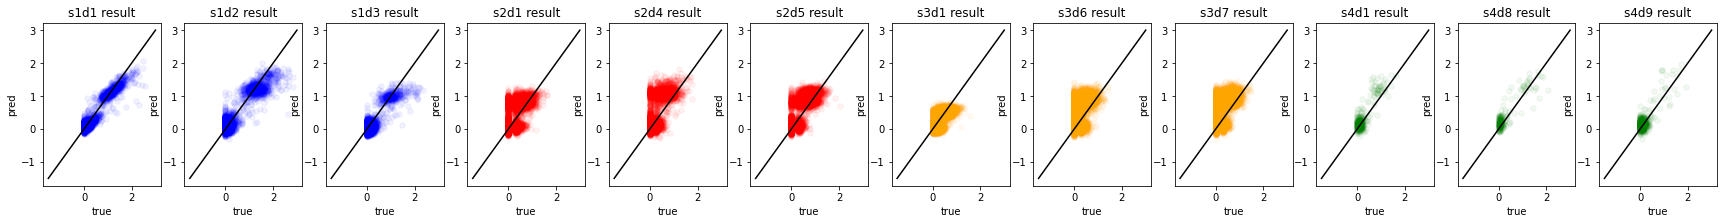

Epoch  16100 s1d1:  0.13217822 s1d2:  0.43565142 s1d3:  0.38573062 s2d1: 0.44105974 s2d4: 0.6300997 s2d5: 0.45696968 s3d1: 0.510175 s3d6: 0.6172987 s3d7: 0.55001515 s4d1: 0.5359142 s4d8: 0.5077745 s4d9: 0.59231085
Epoch  16200 s1d1:  0.13157003 s1d2:  0.43634823 s1d3:  0.3855314 s2d1: 0.44152382 s2d4: 0.63138735 s2d5: 0.45753208 s3d1: 0.5098228 s3d6: 0.6181914 s3d7: 0.55099326 s4d1: 0.5371108 s4d8: 0.509193 s4d9: 0.5936072
Epoch  16300 s1d1:  0.13106838 s1d2:  0.4361972 s1d3:  0.38560414 s2d1: 0.44144386 s2d4: 0.63143015 s2d5: 0.45748293 s3d1: 0.5098844 s3d6: 0.6180228 s3d7: 0.5507227 s4d1: 0.5372978 s4d8: 0.50919515 s4d9: 0.59368837
Epoch  16400 s1d1:  0.13057904 s1d2:  0.43665794 s1d3:  0.3856438 s2d1: 0.4415855 s2d4: 0.63177514 s2d5: 0.4576746 s3d1: 0.50976425 s3d6: 0.6184065 s3d7: 0.551161 s4d1: 0.53763473 s4d8: 0.5095367 s4d9: 0.5940528
Epoch  16500 s1d1:  0.13006815 s1d2:  0.43687874 s1d3:  0.3855893 s2d1: 0.4417693 s2d4: 0.63229334 s2d5: 0.45789456 s3d1: 0.5096962 s3d6: 0.618800

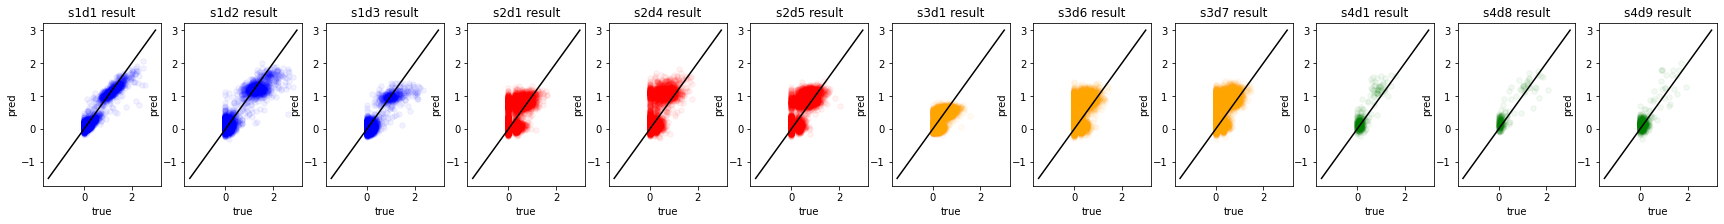

Epoch  17100 s1d1:  0.12745182 s1d2:  0.43651298 s1d3:  0.3865263 s2d1: 0.44119737 s2d4: 0.63124764 s2d5: 0.45756388 s3d1: 0.5098853 s3d6: 0.6179321 s3d7: 0.55086803 s4d1: 0.53759104 s4d8: 0.50974566 s4d9: 0.5939404
Epoch  17200 s1d1:  0.126902 s1d2:  0.4369498 s1d3:  0.38651913 s2d1: 0.44153523 s2d4: 0.6321718 s2d5: 0.45784968 s3d1: 0.5098045 s3d6: 0.6184851 s3d7: 0.55145836 s4d1: 0.5382971 s4d8: 0.5101645 s4d9: 0.5945942
Epoch  17300 s1d1:  0.12645982 s1d2:  0.43719903 s1d3:  0.3864973 s2d1: 0.4417945 s2d4: 0.63245654 s2d5: 0.4581903 s3d1: 0.5099693 s3d6: 0.618937 s3d7: 0.5518585 s4d1: 0.53867686 s4d8: 0.5106526 s4d9: 0.59517586
Epoch  17400 s1d1:  0.12602462 s1d2:  0.43712065 s1d3:  0.38651437 s2d1: 0.44170433 s2d4: 0.6322546 s2d5: 0.45809653 s3d1: 0.50982183 s3d6: 0.6187038 s3d7: 0.5514865 s4d1: 0.5386201 s4d8: 0.51066494 s4d9: 0.59521365
Epoch  17500 s1d1:  0.12545286 s1d2:  0.43786076 s1d3:  0.38612813 s2d1: 0.4423527 s2d4: 0.63386387 s2d5: 0.45872906 s3d1: 0.50936204 s3d6: 0.619

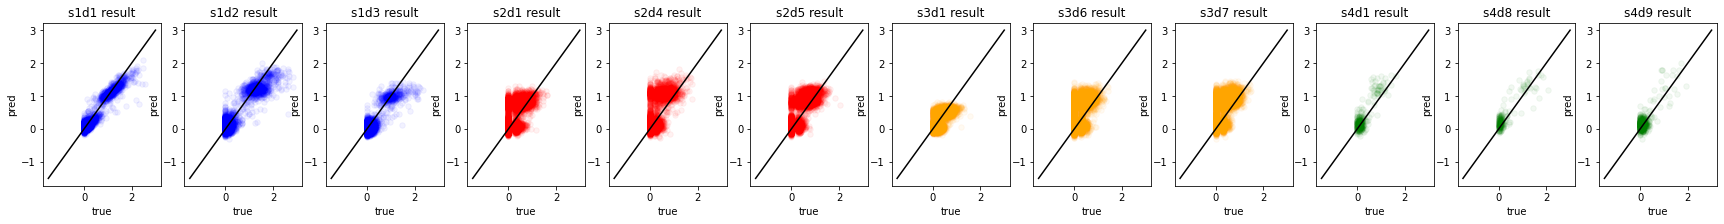

Epoch  18100 s1d1:  0.122925125 s1d2:  0.43803078 s1d3:  0.38684064 s2d1: 0.4421346 s2d4: 0.63352126 s2d5: 0.45869473 s3d1: 0.50946254 s3d6: 0.6195558 s3d7: 0.5524754 s4d1: 0.5401512 s4d8: 0.5121719 s4d9: 0.59665626
Epoch  18200 s1d1:  0.12256444 s1d2:  0.4381833 s1d3:  0.38698098 s2d1: 0.44219667 s2d4: 0.6333467 s2d5: 0.4588299 s3d1: 0.5097615 s3d6: 0.6198047 s3d7: 0.55277705 s4d1: 0.540356 s4d8: 0.5122313 s4d9: 0.5967952
Epoch  18300 s1d1:  0.12204973 s1d2:  0.43851346 s1d3:  0.386821 s2d1: 0.44257498 s2d4: 0.6347612 s2d5: 0.4591292 s3d1: 0.509363 s3d6: 0.6203548 s3d7: 0.5534155 s4d1: 0.54103565 s4d8: 0.51319164 s4d9: 0.5977796
Epoch  18400 s1d1:  0.12170709 s1d2:  0.43828636 s1d3:  0.38724545 s2d1: 0.44215578 s2d4: 0.6335722 s2d5: 0.45886177 s3d1: 0.50962085 s3d6: 0.6198301 s3d7: 0.5529489 s4d1: 0.5404585 s4d8: 0.5122476 s4d9: 0.59678894
Epoch  18500 s1d1:  0.121364504 s1d2:  0.43819153 s1d3:  0.38745287 s2d1: 0.44209898 s2d4: 0.6331733 s2d5: 0.45882213 s3d1: 0.5097505 s3d6: 0.61953

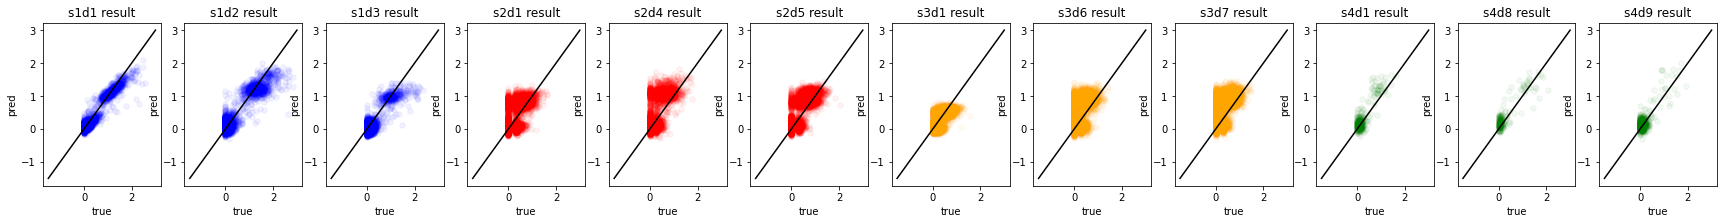

Epoch  19100 s1d1:  0.11893576 s1d2:  0.43863702 s1d3:  0.38788238 s2d1: 0.44211406 s2d4: 0.6340423 s2d5: 0.45896193 s3d1: 0.5095518 s3d6: 0.6198389 s3d7: 0.55306965 s4d1: 0.54086626 s4d8: 0.5130052 s4d9: 0.59732264
Epoch  19200 s1d1:  0.118503936 s1d2:  0.438866 s1d3:  0.3877758 s2d1: 0.44252113 s2d4: 0.6344878 s2d5: 0.45937768 s3d1: 0.50956607 s3d6: 0.6203973 s3d7: 0.5534219 s4d1: 0.54165137 s4d8: 0.51357615 s4d9: 0.59817195
Epoch  19300 s1d1:  0.1180987 s1d2:  0.43918338 s1d3:  0.3876982 s2d1: 0.4424629 s2d4: 0.6346735 s2d5: 0.45936885 s3d1: 0.50925606 s3d6: 0.62043965 s3d7: 0.5536426 s4d1: 0.54184663 s4d8: 0.5139814 s4d9: 0.5983741
Epoch  19400 s1d1:  0.11766749 s1d2:  0.43925995 s1d3:  0.38768408 s2d1: 0.44245094 s2d4: 0.6353482 s2d5: 0.4592873 s3d1: 0.5090456 s3d6: 0.62063044 s3d7: 0.5539216 s4d1: 0.54194725 s4d8: 0.51440316 s4d9: 0.5985455
Epoch  19500 s1d1:  0.11743584 s1d2:  0.4386985 s1d3:  0.38812938 s2d1: 0.44218007 s2d4: 0.63409036 s2d5: 0.4590787 s3d1: 0.50951725 s3d6: 0.

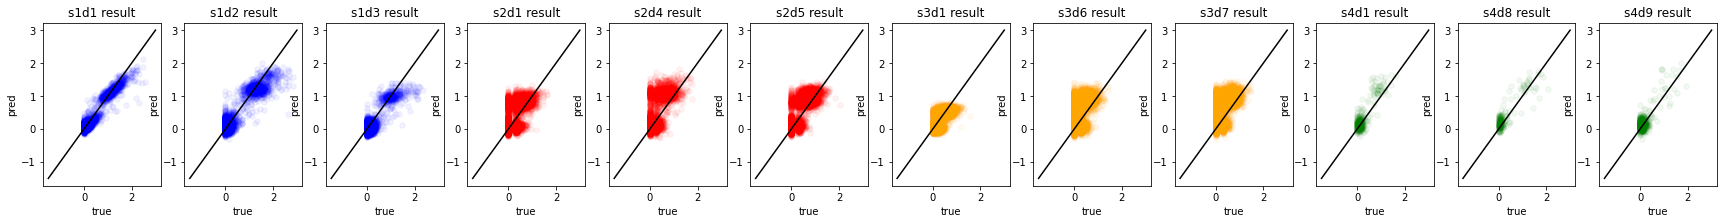

Epoch  20100 s1d1:  0.11507208 s1d2:  0.43963024 s1d3:  0.38827655 s2d1: 0.44258356 s2d4: 0.6352991 s2d5: 0.4596565 s3d1: 0.5091545 s3d6: 0.6207655 s3d7: 0.5540286 s4d1: 0.54265004 s4d8: 0.5148327 s4d9: 0.5991493
Epoch  20200 s1d1:  0.11477888 s1d2:  0.4393614 s1d3:  0.3884462 s2d1: 0.4422095 s2d4: 0.63470715 s2d5: 0.4593914 s3d1: 0.50940335 s3d6: 0.6202615 s3d7: 0.5535186 s4d1: 0.542151 s4d8: 0.51453084 s4d9: 0.5987862
Epoch  20300 s1d1:  0.114441514 s1d2:  0.439491 s1d3:  0.38869628 s2d1: 0.4424735 s2d4: 0.6350318 s2d5: 0.45958576 s3d1: 0.5094433 s3d6: 0.6207382 s3d7: 0.5541186 s4d1: 0.5423105 s4d8: 0.51467544 s4d9: 0.5988081
Epoch  20400 s1d1:  0.11402295 s1d2:  0.43984655 s1d3:  0.38863626 s2d1: 0.44263825 s2d4: 0.6355845 s2d5: 0.45981508 s3d1: 0.5090754 s3d6: 0.62103635 s3d7: 0.5543598 s4d1: 0.5428819 s4d8: 0.5153766 s4d9: 0.5996205
Epoch  20500 s1d1:  0.11363547 s1d2:  0.44003668 s1d3:  0.3884618 s2d1: 0.44279557 s2d4: 0.63591844 s2d5: 0.45993856 s3d1: 0.5091329 s3d6: 0.6213854 s

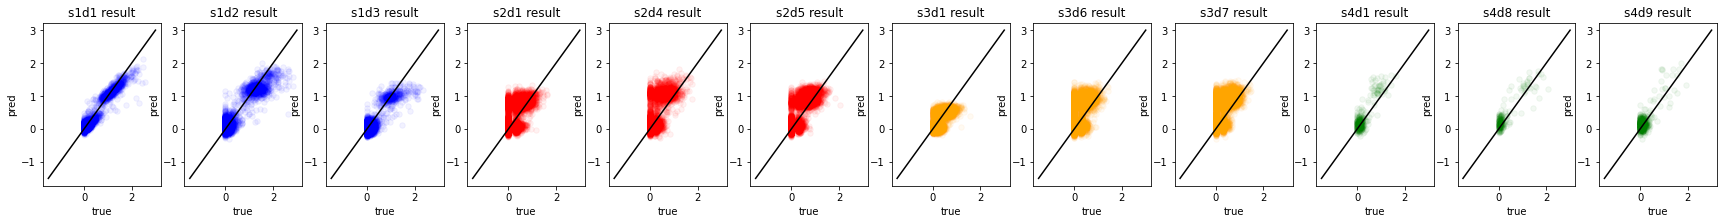

Epoch  21100 s1d1:  0.111598134 s1d2:  0.4399387 s1d3:  0.3891195 s2d1: 0.4423997 s2d4: 0.63563335 s2d5: 0.45963392 s3d1: 0.5090193 s3d6: 0.6206889 s3d7: 0.5540993 s4d1: 0.5431374 s4d8: 0.51571417 s4d9: 0.5997515
Epoch  21200 s1d1:  0.11118489 s1d2:  0.44058445 s1d3:  0.38899082 s2d1: 0.44285768 s2d4: 0.63664186 s2d5: 0.46017796 s3d1: 0.50879675 s3d6: 0.6216222 s3d7: 0.55523396 s4d1: 0.54393107 s4d8: 0.51651675 s4d9: 0.6006539
Epoch  21300 s1d1:  0.11097414 s1d2:  0.4400812 s1d3:  0.3894399 s2d1: 0.4426552 s2d4: 0.6356488 s2d5: 0.4599447 s3d1: 0.5091212 s3d6: 0.6210155 s3d7: 0.5544897 s4d1: 0.54309887 s4d8: 0.51558816 s4d9: 0.5996796
Epoch  21400 s1d1:  0.11047276 s1d2:  0.44090143 s1d3:  0.38878578 s2d1: 0.44308963 s2d4: 0.6376928 s2d5: 0.46036652 s3d1: 0.5084728 s3d6: 0.6220342 s3d7: 0.55556893 s4d1: 0.5446359 s4d8: 0.51739407 s4d9: 0.6016141
Epoch  21500 s1d1:  0.11029411 s1d2:  0.4401958 s1d3:  0.3894434 s2d1: 0.44265154 s2d4: 0.6357862 s2d5: 0.46000358 s3d1: 0.50903 s3d6: 0.621181

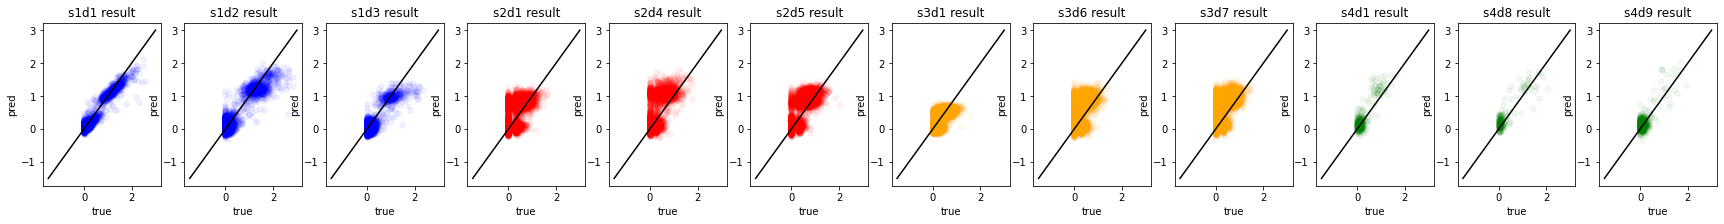

Epoch  22100 s1d1:  0.108268924 s1d2:  0.4408849 s1d3:  0.3896959 s2d1: 0.4429074 s2d4: 0.6369672 s2d5: 0.46040493 s3d1: 0.50863993 s3d6: 0.6217909 s3d7: 0.5555121 s4d1: 0.5445179 s4d8: 0.51724005 s4d9: 0.60107553
Epoch  22200 s1d1:  0.10806058 s1d2:  0.4406047 s1d3:  0.39000487 s2d1: 0.44263685 s2d4: 0.63601 s2d5: 0.46022856 s3d1: 0.50892234 s3d6: 0.62134296 s3d7: 0.5548797 s4d1: 0.54411364 s4d8: 0.516805 s4d9: 0.6006266
Epoch  22300 s1d1:  0.107588395 s1d2:  0.44127816 s1d3:  0.38963634 s2d1: 0.44312528 s2d4: 0.637589 s2d5: 0.4606808 s3d1: 0.50848484 s3d6: 0.622108 s3d7: 0.55575144 s4d1: 0.54519814 s4d8: 0.51790905 s4d9: 0.60193086
Epoch  22400 s1d1:  0.107380584 s1d2:  0.44092256 s1d3:  0.38987792 s2d1: 0.44291222 s2d4: 0.63671297 s2d5: 0.46047005 s3d1: 0.508891 s3d6: 0.6217686 s3d7: 0.55528635 s4d1: 0.54465103 s4d8: 0.51721305 s4d9: 0.6013392
Epoch  22500 s1d1:  0.106970474 s1d2:  0.44127634 s1d3:  0.38965914 s2d1: 0.44315708 s2d4: 0.6372324 s2d5: 0.46075186 s3d1: 0.5086355 s3d6: 0

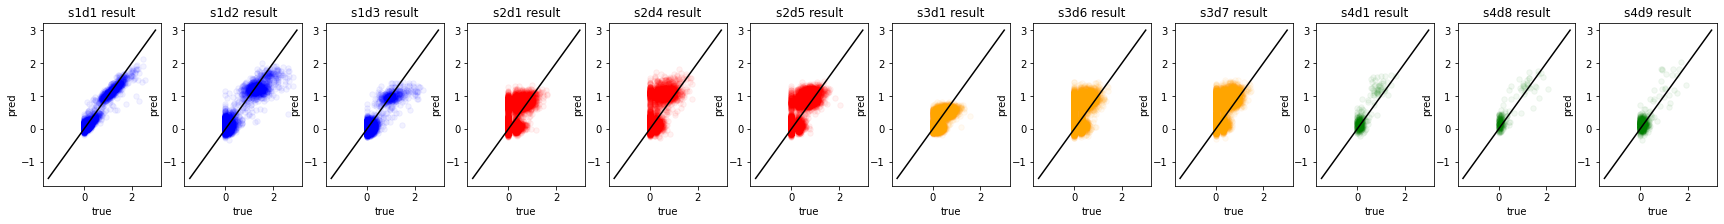

Epoch  23100 s1d1:  0.10524709 s1d2:  0.44130382 s1d3:  0.39033642 s2d1: 0.44279543 s2d4: 0.63696915 s2d5: 0.4604595 s3d1: 0.50878495 s3d6: 0.6218869 s3d7: 0.5554945 s4d1: 0.54507667 s4d8: 0.5179622 s4d9: 0.6017637
Epoch  23200 s1d1:  0.104900695 s1d2:  0.44138184 s1d3:  0.3903699 s2d1: 0.44301587 s2d4: 0.6375122 s2d5: 0.46067002 s3d1: 0.50859654 s3d6: 0.6222548 s3d7: 0.55601746 s4d1: 0.5453754 s4d8: 0.5180978 s4d9: 0.60195583
Epoch  23300 s1d1:  0.10450152 s1d2:  0.44189 s1d3:  0.39012244 s2d1: 0.44319123 s2d4: 0.6384092 s2d5: 0.46083385 s3d1: 0.50825566 s3d6: 0.62255496 s3d7: 0.5562749 s4d1: 0.54610187 s4d8: 0.5188803 s4d9: 0.6028672
Epoch  23400 s1d1:  0.104405016 s1d2:  0.441226 s1d3:  0.39073178 s2d1: 0.44268796 s2d4: 0.6369193 s2d5: 0.4603993 s3d1: 0.5087541 s3d6: 0.6217348 s3d7: 0.5554527 s4d1: 0.54505557 s4d8: 0.51795673 s4d9: 0.6016396
Epoch  23500 s1d1:  0.10392414 s1d2:  0.44214904 s1d3:  0.39004594 s2d1: 0.44335285 s2d4: 0.63836586 s2d5: 0.46117756 s3d1: 0.50831044 s3d6: 0.

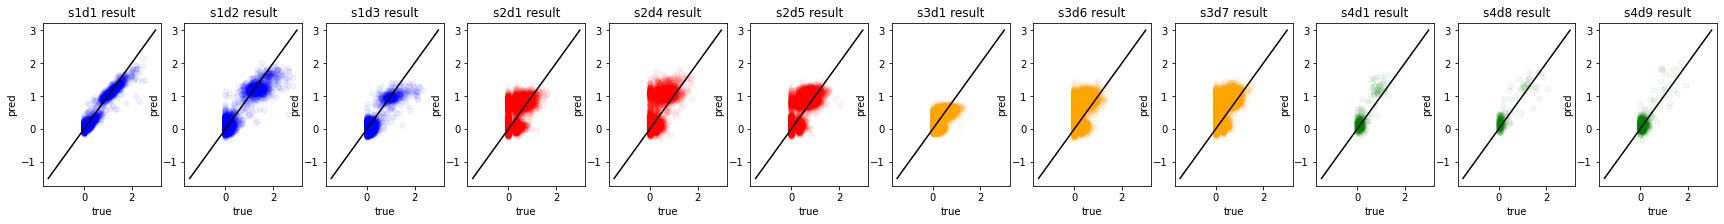

Epoch  24100 s1d1:  0.10223786 s1d2:  0.44205254 s1d3:  0.39062968 s2d1: 0.44325563 s2d4: 0.6383482 s2d5: 0.4611527 s3d1: 0.5083104 s3d6: 0.6226858 s3d7: 0.55646276 s4d1: 0.5466702 s4d8: 0.519479 s4d9: 0.60335356
Epoch  24200 s1d1:  0.102061674 s1d2:  0.44167176 s1d3:  0.39093626 s2d1: 0.44284973 s2d4: 0.6376609 s2d5: 0.46072897 s3d1: 0.5083865 s3d6: 0.62214327 s3d7: 0.5559636 s4d1: 0.5458985 s4d8: 0.5188746 s4d9: 0.6024611
Epoch  24300 s1d1:  0.10189115 s1d2:  0.44139972 s1d3:  0.39130747 s2d1: 0.4427617 s2d4: 0.6372349 s2d5: 0.4605954 s3d1: 0.5086042 s3d6: 0.62186724 s3d7: 0.55565745 s4d1: 0.5453885 s4d8: 0.5183909 s4d9: 0.6021132
Epoch  24400 s1d1:  0.10139693 s1d2:  0.44240835 s1d3:  0.390632 s2d1: 0.4434022 s2d4: 0.6386844 s2d5: 0.46137768 s3d1: 0.50805056 s3d6: 0.62305105 s3d7: 0.5567814 s4d1: 0.5471157 s4d8: 0.5200859 s4d9: 0.60396826
Epoch  24500 s1d1:  0.101152204 s1d2:  0.44218263 s1d3:  0.3909876 s2d1: 0.44309485 s2d4: 0.6385428 s2d5: 0.46101657 s3d1: 0.5080545 s3d6: 0.62262

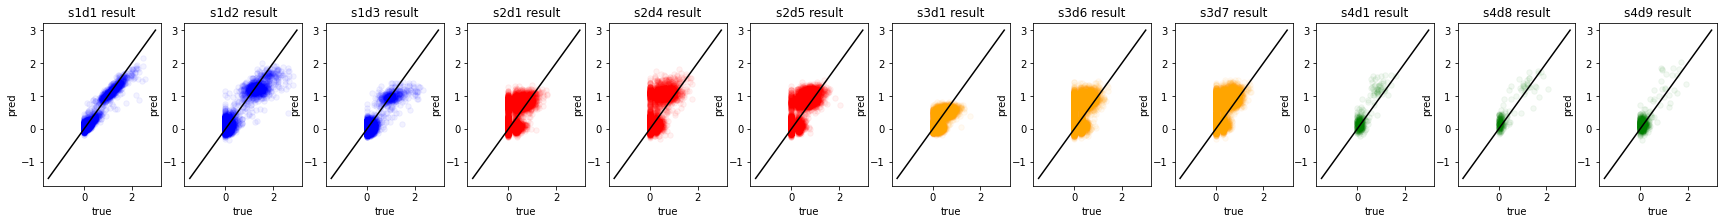

Epoch  25100 s1d1:  0.09969867 s1d2:  0.4422364 s1d3:  0.39152107 s2d1: 0.44289437 s2d4: 0.6379918 s2d5: 0.46092486 s3d1: 0.50817 s3d6: 0.62262636 s3d7: 0.55659765 s4d1: 0.54629135 s4d8: 0.5196791 s4d9: 0.60302645
Epoch  25200 s1d1:  0.099132635 s1d2:  0.4429684 s1d3:  0.39091405 s2d1: 0.4438009 s2d4: 0.6405761 s2d5: 0.461734 s3d1: 0.50765884 s3d6: 0.6239782 s3d7: 0.5578939 s4d1: 0.5485266 s4d8: 0.5216353 s4d9: 0.60546374
Epoch  25300 s1d1:  0.09891543 s1d2:  0.44292906 s1d3:  0.39099747 s2d1: 0.44346806 s2d4: 0.63960874 s2d5: 0.46145594 s3d1: 0.50762177 s3d6: 0.62330216 s3d7: 0.55729795 s4d1: 0.54784393 s4d8: 0.52112216 s4d9: 0.60478485
Epoch  25400 s1d1:  0.09883767 s1d2:  0.4423788 s1d3:  0.3916668 s2d1: 0.44302902 s2d4: 0.6383444 s2d5: 0.46100277 s3d1: 0.50798994 s3d6: 0.6225094 s3d7: 0.5563675 s4d1: 0.5468233 s4d8: 0.52005213 s4d9: 0.6035109
Epoch  25500 s1d1:  0.098457344 s1d2:  0.4427064 s1d3:  0.3913502 s2d1: 0.4433468 s2d4: 0.6391757 s2d5: 0.4614261 s3d1: 0.50794023 s3d6: 0.62

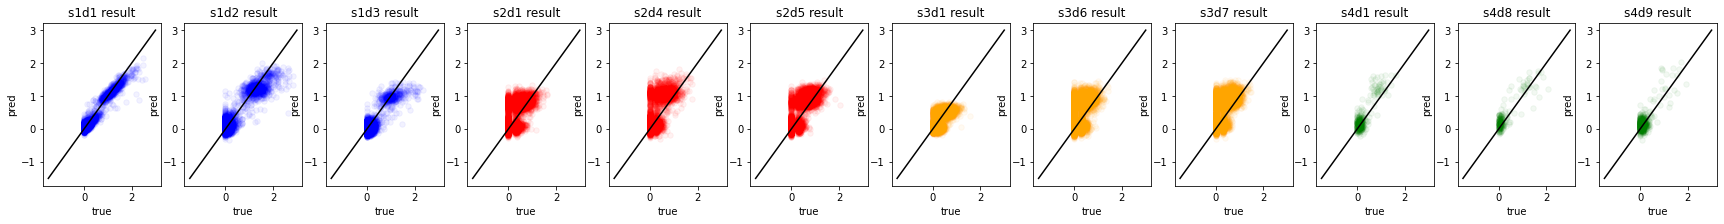

Epoch  26100 s1d1:  0.09683194 s1d2:  0.4433966 s1d3:  0.39135396 s2d1: 0.44379595 s2d4: 0.64064187 s2d5: 0.4620579 s3d1: 0.50758415 s3d6: 0.6241449 s3d7: 0.55826205 s4d1: 0.54910034 s4d8: 0.52229804 s4d9: 0.60587937
Epoch  26200 s1d1:  0.096705094 s1d2:  0.44309032 s1d3:  0.39165488 s2d1: 0.4433223 s2d4: 0.63932633 s2d5: 0.46163502 s3d1: 0.50768995 s3d6: 0.6232814 s3d7: 0.55738646 s4d1: 0.54825586 s4d8: 0.5214168 s4d9: 0.6048752
Epoch  26300 s1d1:  0.0963807 s1d2:  0.4435475 s1d3:  0.39168248 s2d1: 0.44352928 s2d4: 0.64053303 s2d5: 0.46179616 s3d1: 0.5073529 s3d6: 0.6238159 s3d7: 0.5582982 s4d1: 0.548697 s4d8: 0.5222197 s4d9: 0.60540587
Epoch  26400 s1d1:  0.09613668 s1d2:  0.44352415 s1d3:  0.3918049 s2d1: 0.44362512 s2d4: 0.64041144 s2d5: 0.46185258 s3d1: 0.5074557 s3d6: 0.6239968 s3d7: 0.55828744 s4d1: 0.54875493 s4d8: 0.52204543 s4d9: 0.6053987
Epoch  26500 s1d1:  0.09604593 s1d2:  0.44311267 s1d3:  0.3921094 s2d1: 0.44321877 s2d4: 0.63937336 s2d5: 0.4615656 s3d1: 0.5076149 s3d6: 

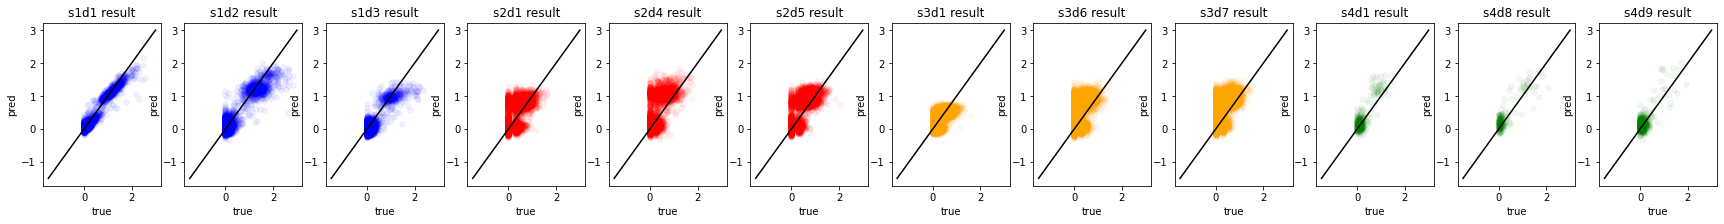

Epoch  27100 s1d1:  0.094421744 s1d2:  0.44408804 s1d3:  0.3919254 s2d1: 0.44384867 s2d4: 0.6415261 s2d5: 0.4623518 s3d1: 0.50724894 s3d6: 0.6246203 s3d7: 0.5588842 s4d1: 0.5498651 s4d8: 0.5231837 s4d9: 0.60674447
Epoch  27200 s1d1:  0.09426373 s1d2:  0.4436852 s1d3:  0.39193067 s2d1: 0.44362038 s2d4: 0.64052755 s2d5: 0.46211308 s3d1: 0.50745 s3d6: 0.6240765 s3d7: 0.558233 s4d1: 0.54939556 s4d8: 0.5227146 s4d9: 0.60610574
Epoch  27300 s1d1:  0.09412429 s1d2:  0.44338065 s1d3:  0.39238614 s2d1: 0.4432377 s2d4: 0.63995713 s2d5: 0.46166092 s3d1: 0.5074582 s3d6: 0.6233884 s3d7: 0.5577895 s4d1: 0.54848576 s4d8: 0.5220426 s4d9: 0.6050052
Epoch  27400 s1d1:  0.0938402 s1d2:  0.44364995 s1d3:  0.39222363 s2d1: 0.44334164 s2d4: 0.6404132 s2d5: 0.4617728 s3d1: 0.5072964 s3d6: 0.6238204 s3d7: 0.5581352 s4d1: 0.5489172 s4d8: 0.5225678 s4d9: 0.6055727
Epoch  27500 s1d1:  0.093482114 s1d2:  0.44424373 s1d3:  0.39205268 s2d1: 0.44389147 s2d4: 0.6414484 s2d5: 0.46243057 s3d1: 0.50721955 s3d6: 0.62464 

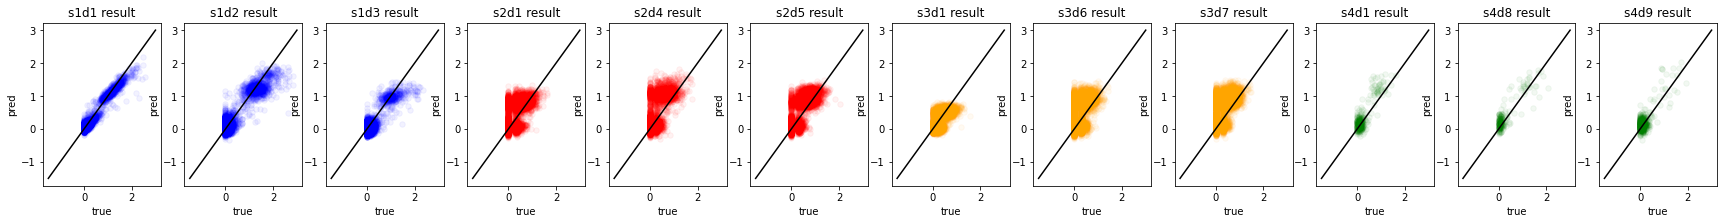

Epoch  28100 s1d1:  0.09208769 s1d2:  0.44469514 s1d3:  0.39188966 s2d1: 0.44416058 s2d4: 0.6422939 s2d5: 0.46268162 s3d1: 0.5068569 s3d6: 0.62507606 s3d7: 0.5594658 s4d1: 0.55103046 s4d8: 0.5246663 s4d9: 0.60800475
Epoch  28200 s1d1:  0.09189107 s1d2:  0.4448492 s1d3:  0.3919088 s2d1: 0.44430348 s2d4: 0.6423218 s2d5: 0.46281925 s3d1: 0.5067554 s3d6: 0.6253501 s3d7: 0.55947536 s4d1: 0.55142105 s4d8: 0.5246132 s4d9: 0.60817504
Epoch  28300 s1d1:  0.09172555 s1d2:  0.44439203 s1d3:  0.39234766 s2d1: 0.44396937 s2d4: 0.64143676 s2d5: 0.46260044 s3d1: 0.5071684 s3d6: 0.6247712 s3d7: 0.5589811 s4d1: 0.55062956 s4d8: 0.5239331 s4d9: 0.6073656
Epoch  28400 s1d1:  0.09162961 s1d2:  0.4437684 s1d3:  0.39286944 s2d1: 0.44331163 s2d4: 0.6403506 s2d5: 0.4619149 s3d1: 0.50734454 s3d6: 0.6236991 s3d7: 0.55806214 s4d1: 0.5494988 s4d8: 0.52318853 s4d9: 0.6060934
Epoch  28500 s1d1:  0.09135979 s1d2:  0.4440693 s1d3:  0.39256185 s2d1: 0.44354486 s2d4: 0.6411485 s2d5: 0.4620889 s3d1: 0.50710124 s3d6: 0.6

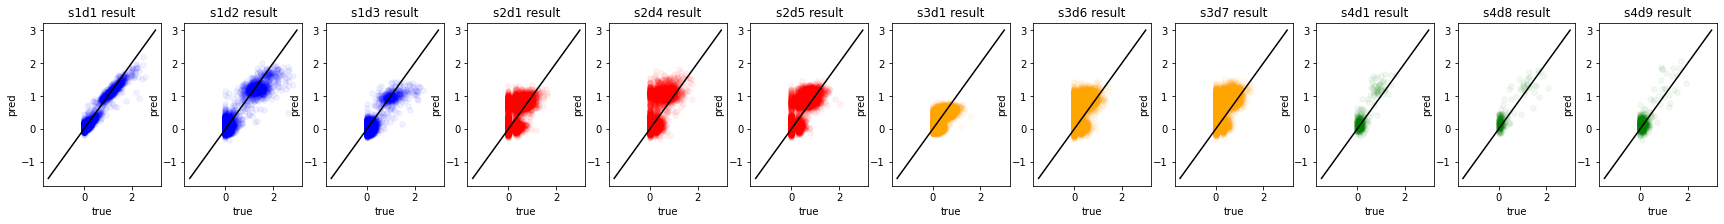

Epoch  29100 s1d1:  0.09001415 s1d2:  0.44444072 s1d3:  0.3927414 s2d1: 0.44393235 s2d4: 0.64196783 s2d5: 0.46262068 s3d1: 0.5066996 s3d6: 0.6249192 s3d7: 0.55943394 s4d1: 0.5506818 s4d8: 0.5243959 s4d9: 0.6075348
Epoch  29200 s1d1:  0.089947894 s1d2:  0.4441648 s1d3:  0.39313143 s2d1: 0.4434795 s2d4: 0.64080817 s2d5: 0.46225107 s3d1: 0.50687987 s3d6: 0.6241654 s3d7: 0.5587643 s4d1: 0.54985857 s4d8: 0.5236622 s4d9: 0.6065468
Epoch  29300 s1d1:  0.0897127 s1d2:  0.4445476 s1d3:  0.39307788 s2d1: 0.4436084 s2d4: 0.64109445 s2d5: 0.46246675 s3d1: 0.50666386 s3d6: 0.62452024 s3d7: 0.55902755 s4d1: 0.5502996 s4d8: 0.52424186 s4d9: 0.6071337
Epoch  29400 s1d1:  0.08962353 s1d2:  0.4438636 s1d3:  0.3936031 s2d1: 0.4432088 s2d4: 0.64050704 s2d5: 0.4619154 s3d1: 0.5069355 s3d6: 0.62375623 s3d7: 0.55822796 s4d1: 0.54943967 s4d8: 0.5232851 s4d9: 0.6059741
Epoch  29500 s1d1:  0.089188375 s1d2:  0.444799 s1d3:  0.39289132 s2d1: 0.4438742 s2d4: 0.64206463 s2d5: 0.4626534 s3d1: 0.5065857 s3d6: 0.6249

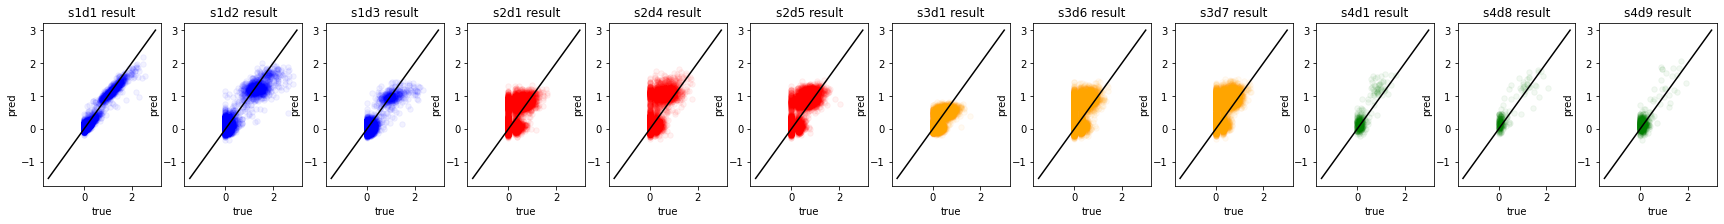

Epoch  30100 s1d1:  0.088216506 s1d2:  0.44418195 s1d3:  0.39375532 s2d1: 0.44320107 s2d4: 0.64074975 s2d5: 0.46213433 s3d1: 0.5067548 s3d6: 0.6239456 s3d7: 0.5586888 s4d1: 0.5497382 s4d8: 0.52377135 s4d9: 0.6064888
Epoch  30200 s1d1:  0.08773812 s1d2:  0.44491076 s1d3:  0.39320368 s2d1: 0.44397366 s2d4: 0.64260066 s2d5: 0.46277383 s3d1: 0.50631464 s3d6: 0.62508094 s3d7: 0.5596343 s4d1: 0.55129987 s4d8: 0.52507126 s4d9: 0.6081239
Epoch  30300 s1d1:  0.087705724 s1d2:  0.4445449 s1d3:  0.39354843 s2d1: 0.44359714 s2d4: 0.64161354 s2d5: 0.46252516 s3d1: 0.50666225 s3d6: 0.62462515 s3d7: 0.55930233 s4d1: 0.55065167 s4d8: 0.5242416 s4d9: 0.60707927
Epoch  30400 s1d1:  0.08745834 s1d2:  0.4447313 s1d3:  0.39357236 s2d1: 0.44355866 s2d4: 0.6419376 s2d5: 0.4624603 s3d1: 0.5064664 s3d6: 0.6246611 s3d7: 0.5593765 s4d1: 0.55080545 s4d8: 0.52470165 s4d9: 0.6074002
Epoch  30500 s1d1:  0.08743198 s1d2:  0.4441395 s1d3:  0.39389938 s2d1: 0.4431541 s2d4: 0.640906 s2d5: 0.46201873 s3d1: 0.5066374 s3d6

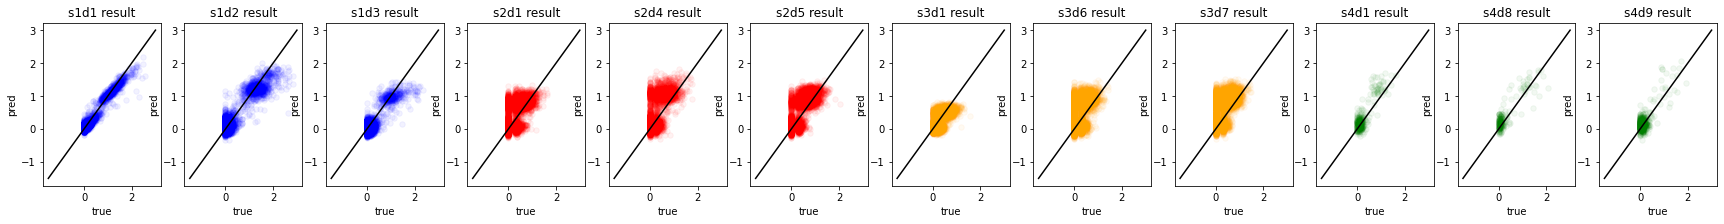

Epoch  31100 s1d1:  0.08602089 s1d2:  0.4454066 s1d3:  0.39344633 s2d1: 0.44408706 s2d4: 0.64294076 s2d5: 0.46306863 s3d1: 0.5062599 s3d6: 0.6256218 s3d7: 0.560236 s4d1: 0.552181 s4d8: 0.52588034 s4d9: 0.60883725
Epoch  31200 s1d1:  0.08588578 s1d2:  0.44517964 s1d3:  0.39347732 s2d1: 0.44393036 s2d4: 0.6428892 s2d5: 0.46289638 s3d1: 0.50617826 s3d6: 0.625194 s3d7: 0.5599985 s4d1: 0.5518107 s4d8: 0.5261029 s4d9: 0.6087078
Epoch  31300 s1d1:  0.085825525 s1d2:  0.44503278 s1d3:  0.39406723 s2d1: 0.4437817 s2d4: 0.6421698 s2d5: 0.4628274 s3d1: 0.50646985 s3d6: 0.62520033 s3d7: 0.55987144 s4d1: 0.551594 s4d8: 0.52529323 s4d9: 0.60802585
Epoch  31400 s1d1:  0.085469835 s1d2:  0.4454383 s1d3:  0.3936878 s2d1: 0.44403434 s2d4: 0.64294595 s2d5: 0.46308383 s3d1: 0.5061015 s3d6: 0.6253864 s3d7: 0.56007016 s4d1: 0.55208373 s4d8: 0.526007 s4d9: 0.60882926
Epoch  31500 s1d1:  0.08544683 s1d2:  0.44495475 s1d3:  0.39402446 s2d1: 0.44358623 s2d4: 0.6421632 s2d5: 0.46269745 s3d1: 0.5062519 s3d6: 0.62

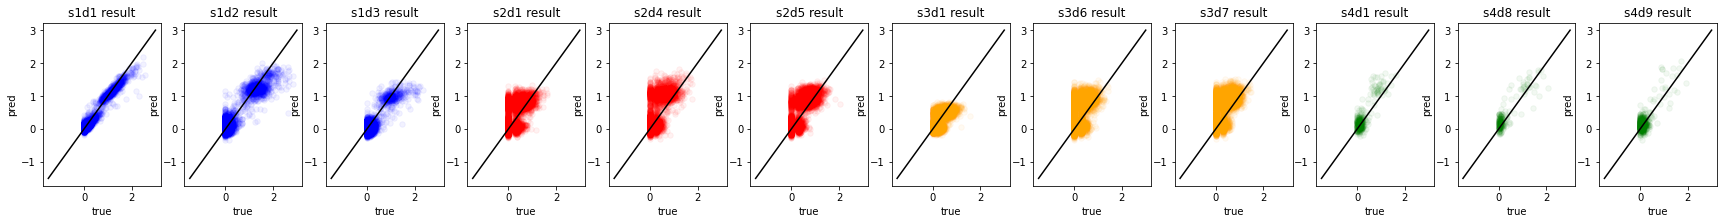

Epoch  32100 s1d1:  0.084288314 s1d2:  0.44559845 s1d3:  0.39395928 s2d1: 0.44405845 s2d4: 0.642963 s2d5: 0.4633125 s3d1: 0.506193 s3d6: 0.6256825 s3d7: 0.5603624 s4d1: 0.55263054 s4d8: 0.5262933 s4d9: 0.6092796
Epoch  32200 s1d1:  0.08419158 s1d2:  0.4449387 s1d3:  0.39426306 s2d1: 0.44375718 s2d4: 0.642416 s2d5: 0.4628827 s3d1: 0.50612634 s3d6: 0.624889 s3d7: 0.55982244 s4d1: 0.55164313 s4d8: 0.5255977 s4d9: 0.6081702
Epoch  32300 s1d1:  0.083974645 s1d2:  0.44574246 s1d3:  0.3941278 s2d1: 0.44395193 s2d4: 0.6427944 s2d5: 0.46322072 s3d1: 0.5059473 s3d6: 0.62555647 s3d7: 0.56060934 s4d1: 0.5523307 s4d8: 0.52638 s4d9: 0.6089569
Epoch  32400 s1d1:  0.08364694 s1d2:  0.44576004 s1d3:  0.3938892 s2d1: 0.44423035 s2d4: 0.6438938 s2d5: 0.46332514 s3d1: 0.50569534 s3d6: 0.62589467 s3d7: 0.5608233 s4d1: 0.5530131 s4d8: 0.52710885 s4d9: 0.60980785
Epoch  32500 s1d1:  0.083707236 s1d2:  0.44522476 s1d3:  0.39440563 s2d1: 0.44370446 s2d4: 0.6424356 s2d5: 0.46284583 s3d1: 0.5062141 s3d6: 0.62498

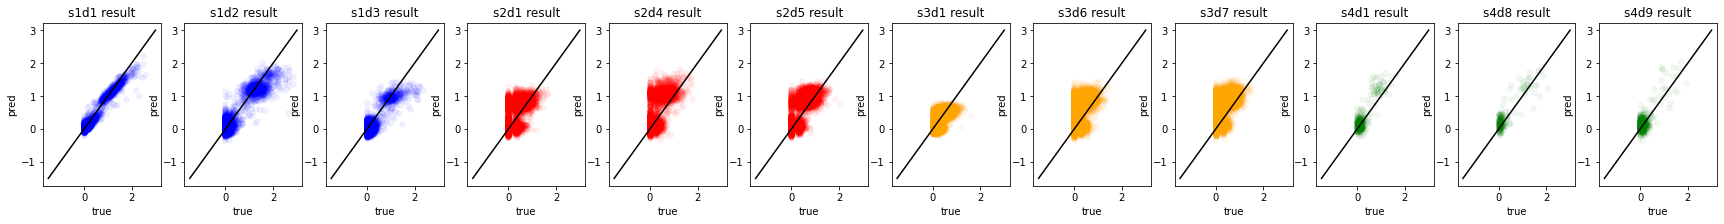

Epoch  33100 s1d1:  0.082562305 s1d2:  0.4456872 s1d3:  0.3944789 s2d1: 0.44377264 s2d4: 0.6433183 s2d5: 0.46305087 s3d1: 0.50559986 s3d6: 0.62532413 s3d7: 0.56043845 s4d1: 0.55236447 s4d8: 0.5268667 s4d9: 0.6090824
Epoch  33200 s1d1:  0.082433924 s1d2:  0.44554305 s1d3:  0.3944629 s2d1: 0.44407448 s2d4: 0.64334875 s2d5: 0.4633621 s3d1: 0.50576735 s3d6: 0.62575823 s3d7: 0.5608017 s4d1: 0.5526341 s4d8: 0.5268 s4d9: 0.6093664
Epoch  33300 s1d1:  0.082293466 s1d2:  0.4458589 s1d3:  0.39444858 s2d1: 0.4438544 s2d4: 0.64300585 s2d5: 0.46332163 s3d1: 0.5057373 s3d6: 0.625556 s3d7: 0.5605824 s4d1: 0.5529673 s4d8: 0.52705324 s4d9: 0.6094216
Epoch  33400 s1d1:  0.08211223 s1d2:  0.44557163 s1d3:  0.39469066 s2d1: 0.44363597 s2d4: 0.6429037 s2d5: 0.46294203 s3d1: 0.50565577 s3d6: 0.6249672 s3d7: 0.55986446 s4d1: 0.5523208 s4d8: 0.5265395 s4d9: 0.6090414
Epoch  33500 s1d1:  0.08199691 s1d2:  0.44543293 s1d3:  0.39477092 s2d1: 0.44361597 s2d4: 0.6427993 s2d5: 0.46291196 s3d1: 0.50573105 s3d6: 0.62

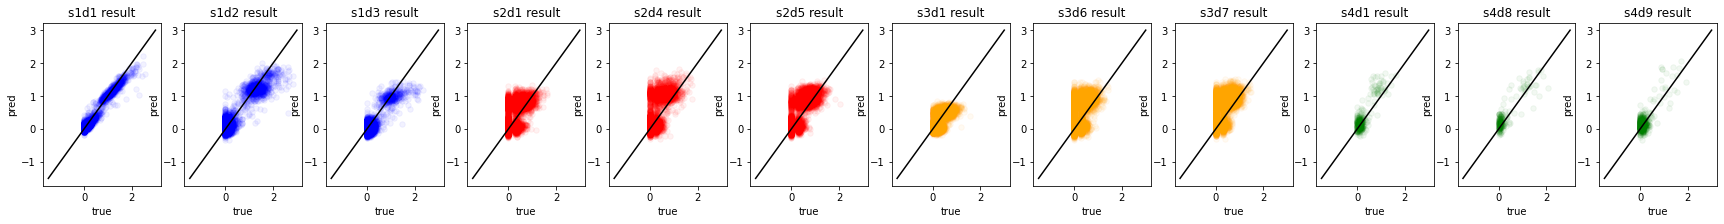

Epoch  34100 s1d1:  0.08114202 s1d2:  0.4455799 s1d3:  0.3951833 s2d1: 0.44366962 s2d4: 0.6425387 s2d5: 0.46309608 s3d1: 0.5058288 s3d6: 0.62525177 s3d7: 0.56033313 s4d1: 0.55233717 s4d8: 0.5265629 s4d9: 0.6086939
Epoch  34200 s1d1:  0.08068111 s1d2:  0.44645387 s1d3:  0.39463243 s2d1: 0.44438013 s2d4: 0.64444715 s2d5: 0.4638292 s3d1: 0.5053514 s3d6: 0.62652445 s3d7: 0.5616128 s4d1: 0.55396223 s4d8: 0.52808833 s4d9: 0.6105018
Epoch  34300 s1d1:  0.080427594 s1d2:  0.44656938 s1d3:  0.39429978 s2d1: 0.44456488 s2d4: 0.645141 s2d5: 0.46391627 s3d1: 0.505127 s3d6: 0.6266121 s3d7: 0.5615376 s4d1: 0.55440223 s4d8: 0.5287235 s4d9: 0.6112408
Epoch  34400 s1d1:  0.08052755 s1d2:  0.4459227 s1d3:  0.39506164 s2d1: 0.44368312 s2d4: 0.6431993 s2d5: 0.46320847 s3d1: 0.5055031 s3d6: 0.62531704 s3d7: 0.5604404 s4d1: 0.5529983 s4d8: 0.52736676 s4d9: 0.60944694
Epoch  34500 s1d1:  0.08012485 s1d2:  0.44667172 s1d3:  0.39459395 s2d1: 0.4443835 s2d4: 0.6449676 s2d5: 0.46383375 s3d1: 0.5050124 s3d6: 0.62

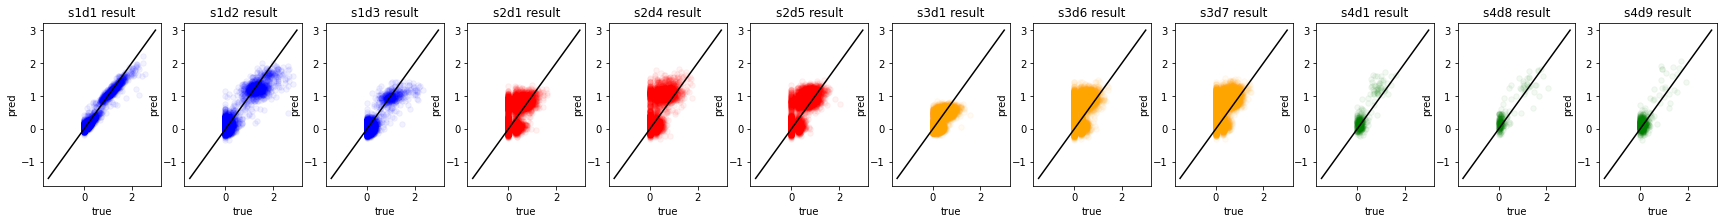

Epoch  35100 s1d1:  0.079267226 s1d2:  0.44643182 s1d3:  0.39490283 s2d1: 0.4440912 s2d4: 0.6444712 s2d5: 0.46367374 s3d1: 0.5051138 s3d6: 0.6261644 s3d7: 0.56116146 s4d1: 0.5540809 s4d8: 0.52838784 s4d9: 0.6107771
Epoch  35200 s1d1:  0.07916141 s1d2:  0.44634482 s1d3:  0.39498502 s2d1: 0.44419658 s2d4: 0.64451194 s2d5: 0.4637444 s3d1: 0.50530714 s3d6: 0.62621236 s3d7: 0.5611797 s4d1: 0.5541524 s4d8: 0.5281689 s4d9: 0.6107363
Epoch  35300 s1d1:  0.078954965 s1d2:  0.44641554 s1d3:  0.39477232 s2d1: 0.4443878 s2d4: 0.6448965 s2d5: 0.46394044 s3d1: 0.5049933 s3d6: 0.6266184 s3d7: 0.5616817 s4d1: 0.55448854 s4d8: 0.5287819 s4d9: 0.61107993
Epoch  35400 s1d1:  0.07871945 s1d2:  0.4471848 s1d3:  0.39457852 s2d1: 0.44474885 s2d4: 0.6458516 s2d5: 0.46437818 s3d1: 0.5048287 s3d6: 0.6272707 s3d7: 0.5624697 s4d1: 0.55530286 s4d8: 0.52953756 s4d9: 0.61193967
Epoch  35500 s1d1:  0.07873737 s1d2:  0.44642675 s1d3:  0.3950435 s2d1: 0.4441001 s2d4: 0.6443291 s2d5: 0.4637519 s3d1: 0.50488436 s3d6: 0.6

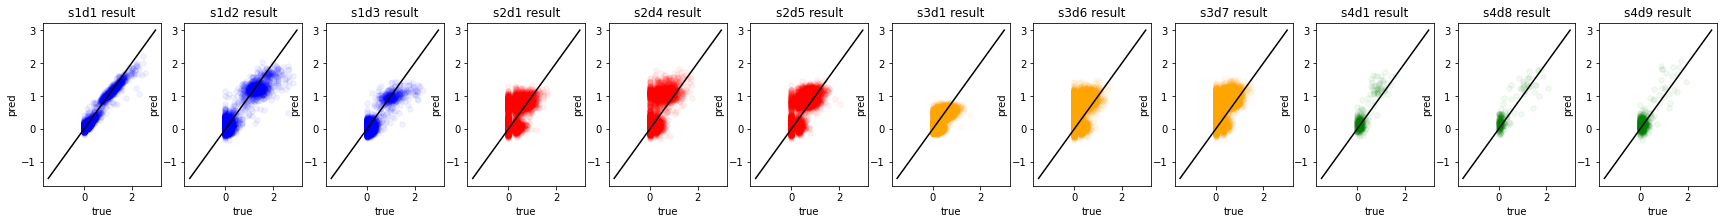

Epoch  36100 s1d1:  0.07783746 s1d2:  0.44662586 s1d3:  0.39518005 s2d1: 0.44429117 s2d4: 0.6446985 s2d5: 0.46393412 s3d1: 0.5048891 s3d6: 0.6265044 s3d7: 0.5616056 s4d1: 0.55439055 s4d8: 0.5287085 s4d9: 0.6111096
Epoch  36200 s1d1:  0.077759445 s1d2:  0.44641933 s1d3:  0.3954035 s2d1: 0.4438404 s2d4: 0.6442231 s2d5: 0.46363056 s3d1: 0.5047963 s3d6: 0.6259244 s3d7: 0.5611384 s4d1: 0.5539781 s4d8: 0.5284625 s4d9: 0.61068124
Epoch  36300 s1d1:  0.07741556 s1d2:  0.44722474 s1d3:  0.3950646 s2d1: 0.444596 s2d4: 0.6458487 s2d5: 0.46434626 s3d1: 0.50451684 s3d6: 0.6272353 s3d7: 0.5625368 s4d1: 0.55524063 s4d8: 0.5296479 s4d9: 0.611994
Epoch  36400 s1d1:  0.07744174 s1d2:  0.44664407 s1d3:  0.39543414 s2d1: 0.44401792 s2d4: 0.6445848 s2d5: 0.46384636 s3d1: 0.5048554 s3d6: 0.6263884 s3d7: 0.56169075 s4d1: 0.55426884 s4d8: 0.5287359 s4d9: 0.6109817
Epoch  36500 s1d1:  0.07716119 s1d2:  0.44710177 s1d3:  0.39526066 s2d1: 0.44450033 s2d4: 0.6457615 s2d5: 0.46421504 s3d1: 0.5046569 s3d6: 0.627152

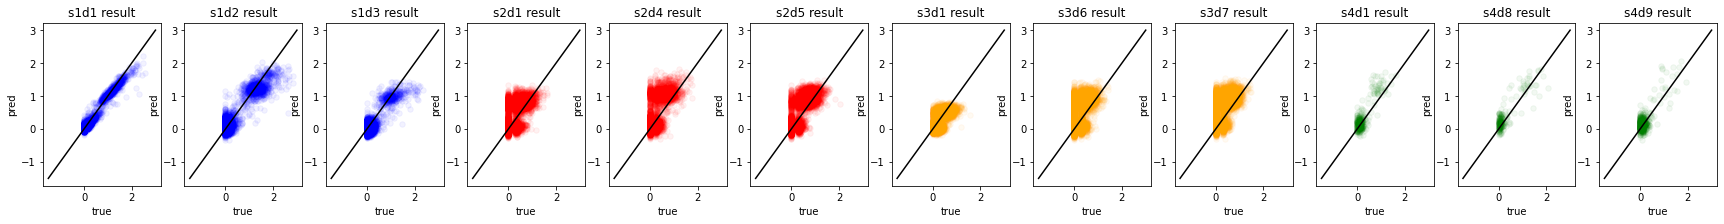

Epoch  37100 s1d1:  0.07633934 s1d2:  0.44711694 s1d3:  0.39535716 s2d1: 0.44454077 s2d4: 0.64580417 s2d5: 0.46429598 s3d1: 0.5043831 s3d6: 0.6270866 s3d7: 0.5624239 s4d1: 0.55543226 s4d8: 0.5297447 s4d9: 0.61200833
Epoch  37200 s1d1:  0.076301455 s1d2:  0.44664773 s1d3:  0.39570338 s2d1: 0.4441713 s2d4: 0.6450768 s2d5: 0.463924 s3d1: 0.5044761 s3d6: 0.6264613 s3d7: 0.56186426 s4d1: 0.5546875 s4d8: 0.5289573 s4d9: 0.61103135
Epoch  37300 s1d1:  0.076090805 s1d2:  0.44699362 s1d3:  0.39549494 s2d1: 0.44440633 s2d4: 0.6456181 s2d5: 0.46418855 s3d1: 0.50453156 s3d6: 0.6269173 s3d7: 0.5622586 s4d1: 0.5553287 s4d8: 0.52975523 s4d9: 0.6118954
Epoch  37400 s1d1:  0.07580774 s1d2:  0.4476911 s1d3:  0.394919 s2d1: 0.44495362 s2d4: 0.6469734 s2d5: 0.4648248 s3d1: 0.5041092 s3d6: 0.6279584 s3d7: 0.5632247 s4d1: 0.55681896 s4d8: 0.53083444 s4d9: 0.61328465
Epoch  37500 s1d1:  0.075803176 s1d2:  0.44730243 s1d3:  0.3953826 s2d1: 0.4446816 s2d4: 0.64595014 s2d5: 0.4645101 s3d1: 0.5044941 s3d6: 0.627

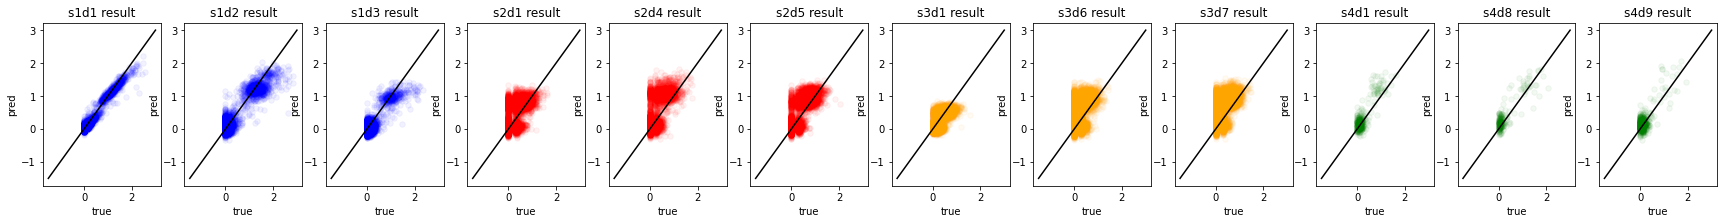

Epoch  38100 s1d1:  0.07492552 s1d2:  0.4475917 s1d3:  0.39532298 s2d1: 0.44493246 s2d4: 0.6468331 s2d5: 0.46475437 s3d1: 0.5039509 s3d6: 0.6278419 s3d7: 0.5632544 s4d1: 0.55652016 s4d8: 0.5308425 s4d9: 0.6130973
Epoch  38200 s1d1:  0.07486366 s1d2:  0.4476878 s1d3:  0.39560494 s2d1: 0.44455147 s2d4: 0.6463935 s2d5: 0.46455795 s3d1: 0.5037961 s3d6: 0.6275903 s3d7: 0.56336284 s4d1: 0.5562032 s4d8: 0.5306406 s4d9: 0.61253446
Epoch  38300 s1d1:  0.07474101 s1d2:  0.44741365 s1d3:  0.39554462 s2d1: 0.44448757 s2d4: 0.64612865 s2d5: 0.46435624 s3d1: 0.50398594 s3d6: 0.6271475 s3d7: 0.56266904 s4d1: 0.5560997 s4d8: 0.5304329 s4d9: 0.6125403
Epoch  38400 s1d1:  0.07503801 s1d2:  0.44615853 s1d3:  0.3965428 s2d1: 0.44340098 s2d4: 0.64406437 s2d5: 0.4632701 s3d1: 0.5043038 s3d6: 0.62547964 s3d7: 0.56137985 s4d1: 0.55358446 s4d8: 0.528621 s4d9: 0.6099705
Epoch  38500 s1d1:  0.074618086 s1d2:  0.44714394 s1d3:  0.3960126 s2d1: 0.44419616 s2d4: 0.6455526 s2d5: 0.46420345 s3d1: 0.50406295 s3d6: 0.6

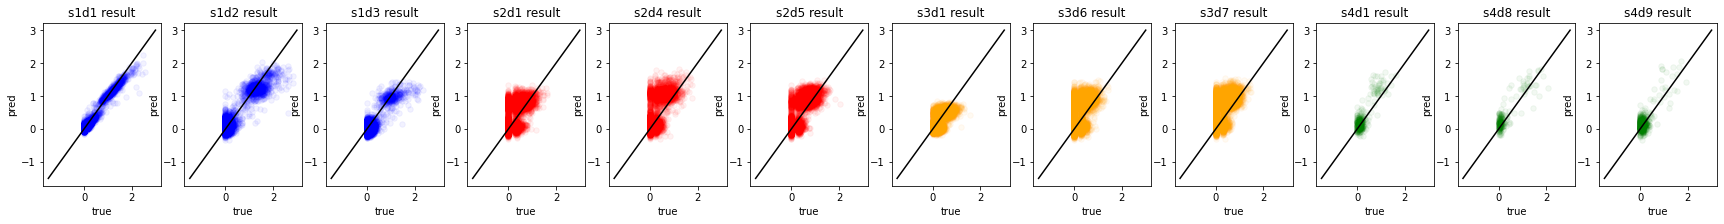

Epoch  39100 s1d1:  0.0737811 s1d2:  0.44754437 s1d3:  0.39582312 s2d1: 0.44454926 s2d4: 0.6460428 s2d5: 0.46462137 s3d1: 0.5037774 s3d6: 0.62738967 s3d7: 0.5630114 s4d1: 0.55635923 s4d8: 0.53070605 s4d9: 0.6126973
Epoch  39200 s1d1:  0.07361198 s1d2:  0.44754443 s1d3:  0.39587307 s2d1: 0.44448087 s2d4: 0.64632887 s2d5: 0.46461344 s3d1: 0.50375503 s3d6: 0.627471 s3d7: 0.56327194 s4d1: 0.5565207 s4d8: 0.53099257 s4d9: 0.61283326
Epoch  39300 s1d1:  0.07357299 s1d2:  0.44767097 s1d3:  0.39610448 s2d1: 0.4443145 s2d4: 0.64578086 s2d5: 0.46441728 s3d1: 0.50398475 s3d6: 0.6272051 s3d7: 0.56287485 s4d1: 0.556116 s4d8: 0.530625 s4d9: 0.6125023
Epoch  39400 s1d1:  0.07355064 s1d2:  0.44700772 s1d3:  0.39653027 s2d1: 0.4439936 s2d4: 0.6452905 s2d5: 0.46400264 s3d1: 0.5039762 s3d6: 0.62647486 s3d7: 0.56221634 s4d1: 0.5551641 s4d8: 0.5297853 s4d9: 0.61141086
Epoch  39500 s1d1:  0.0733501 s1d2:  0.44750726 s1d3:  0.39620626 s2d1: 0.44443724 s2d4: 0.6459799 s2d5: 0.4644767 s3d1: 0.503986 s3d6: 0.62

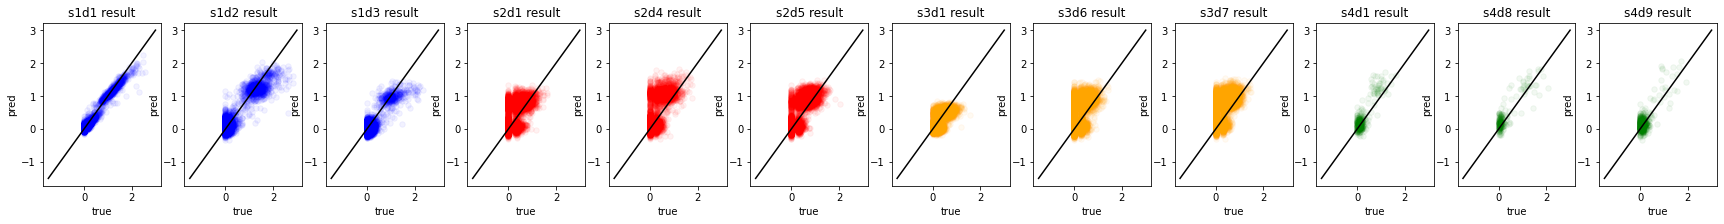

Epoch  40100 s1d1:  0.072524615 s1d2:  0.4478963 s1d3:  0.3961886 s2d1: 0.44461522 s2d4: 0.6469399 s2d5: 0.4647053 s3d1: 0.50357425 s3d6: 0.62779975 s3d7: 0.563551 s4d1: 0.5565567 s4d8: 0.53134406 s4d9: 0.61297
Epoch  40200 s1d1:  0.07247539 s1d2:  0.44753703 s1d3:  0.39606452 s2d1: 0.4444827 s2d4: 0.6460189 s2d5: 0.46460888 s3d1: 0.50356126 s3d6: 0.62722814 s3d7: 0.56266433 s4d1: 0.5564385 s4d8: 0.5309242 s4d9: 0.6128557
Epoch  40300 s1d1:  0.07256197 s1d2:  0.44683775 s1d3:  0.39670768 s2d1: 0.44386965 s2d4: 0.64546233 s2d5: 0.46380517 s3d1: 0.50355387 s3d6: 0.6262735 s3d7: 0.5620574 s4d1: 0.555061 s4d8: 0.53009313 s4d9: 0.61148727
Epoch  40400 s1d1:  0.07220052 s1d2:  0.4477459 s1d3:  0.3962968 s2d1: 0.4445924 s2d4: 0.6466021 s2d5: 0.46482265 s3d1: 0.5035948 s3d6: 0.6276864 s3d7: 0.56324005 s4d1: 0.55692446 s4d8: 0.53127295 s4d9: 0.61327404
Epoch  40500 s1d1:  0.07224429 s1d2:  0.44736445 s1d3:  0.39674887 s2d1: 0.44404626 s2d4: 0.6455031 s2d5: 0.4642958 s3d1: 0.5036787 s3d6: 0.6266

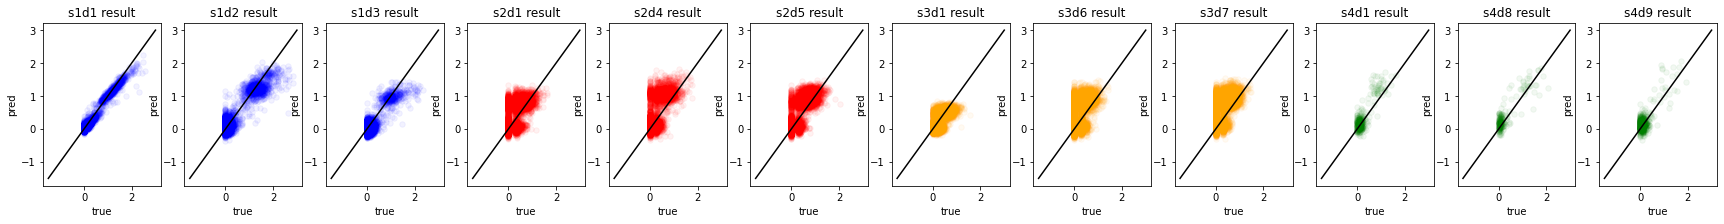

Epoch  41100 s1d1:  0.07139235 s1d2:  0.4477239 s1d3:  0.39630708 s2d1: 0.44461247 s2d4: 0.6468917 s2d5: 0.46484554 s3d1: 0.5032877 s3d6: 0.62759537 s3d7: 0.56328267 s4d1: 0.55715764 s4d8: 0.5318258 s4d9: 0.6135849
Epoch  41200 s1d1:  0.071267016 s1d2:  0.44776857 s1d3:  0.39655998 s2d1: 0.44446895 s2d4: 0.64737356 s2d5: 0.46461293 s3d1: 0.503036 s3d6: 0.62761265 s3d7: 0.56358945 s4d1: 0.55669713 s4d8: 0.53172433 s4d9: 0.613243
Epoch  41300 s1d1:  0.071223944 s1d2:  0.44771788 s1d3:  0.39656377 s2d1: 0.44462144 s2d4: 0.64672494 s2d5: 0.46487245 s3d1: 0.50335693 s3d6: 0.62775975 s3d7: 0.56356615 s4d1: 0.55673784 s4d8: 0.5310698 s4d9: 0.6130448
Epoch  41400 s1d1:  0.07107587 s1d2:  0.4476124 s1d3:  0.39658207 s2d1: 0.44425377 s2d4: 0.6465797 s2d5: 0.46452454 s3d1: 0.5033225 s3d6: 0.6272001 s3d7: 0.5629381 s4d1: 0.5566089 s4d8: 0.53145206 s4d9: 0.6130138
Epoch  41500 s1d1:  0.071150154 s1d2:  0.44725105 s1d3:  0.39677113 s2d1: 0.44395623 s2d4: 0.645588 s2d5: 0.46422625 s3d1: 0.50318056 s3

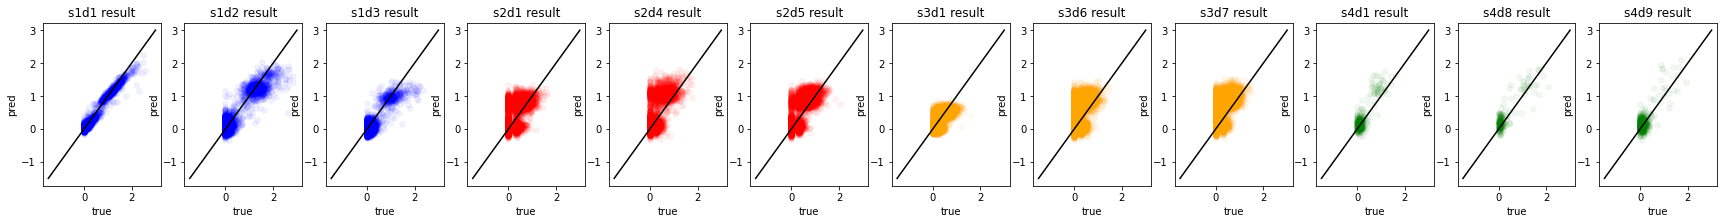

Epoch  42100 s1d1:  0.07024523 s1d2:  0.44814056 s1d3:  0.39648587 s2d1: 0.44441673 s2d4: 0.6470775 s2d5: 0.46496588 s3d1: 0.50277406 s3d6: 0.6276838 s3d7: 0.56370735 s4d1: 0.55736464 s4d8: 0.53202516 s4d9: 0.61371046
Epoch  42200 s1d1:  0.07021363 s1d2:  0.4478652 s1d3:  0.39667702 s2d1: 0.44447607 s2d4: 0.6469465 s2d5: 0.4648366 s3d1: 0.5030548 s3d6: 0.6276963 s3d7: 0.5635474 s4d1: 0.5572978 s4d8: 0.5319239 s4d9: 0.6136398
Epoch  42300 s1d1:  0.07019036 s1d2:  0.44770765 s1d3:  0.39681622 s2d1: 0.44434717 s2d4: 0.6467689 s2d5: 0.46457663 s3d1: 0.5028911 s3d6: 0.6275255 s3d7: 0.563573 s4d1: 0.5567062 s4d8: 0.53159744 s4d9: 0.6130069
Epoch  42400 s1d1:  0.06993383 s1d2:  0.44802475 s1d3:  0.39680722 s2d1: 0.44452113 s2d4: 0.64746016 s2d5: 0.4648524 s3d1: 0.502767 s3d6: 0.6278583 s3d7: 0.56396544 s4d1: 0.557253 s4d8: 0.53206396 s4d9: 0.613714
Epoch  42500 s1d1:  0.06975998 s1d2:  0.44818857 s1d3:  0.3967146 s2d1: 0.44471598 s2d4: 0.64793676 s2d5: 0.46497118 s3d1: 0.50262916 s3d6: 0.6282

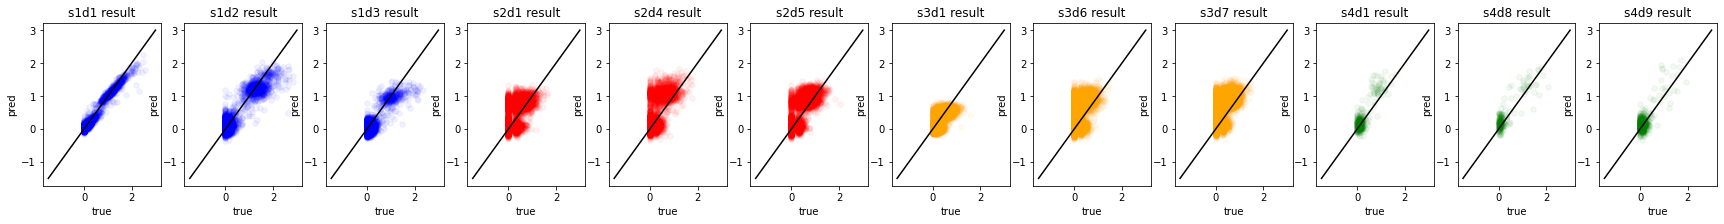

Epoch  43100 s1d1:  0.0693727 s1d2:  0.44759345 s1d3:  0.39720255 s2d1: 0.4439586 s2d4: 0.6465908 s2d5: 0.46434358 s3d1: 0.5025218 s3d6: 0.62693596 s3d7: 0.56300724 s4d1: 0.55654085 s4d8: 0.531471 s4d9: 0.61274534
Epoch  43200 s1d1:  0.06915077 s1d2:  0.4481721 s1d3:  0.39694378 s2d1: 0.44461104 s2d4: 0.6475893 s2d5: 0.46501786 s3d1: 0.5026386 s3d6: 0.6282821 s3d7: 0.5645121 s4d1: 0.55761635 s4d8: 0.53237313 s4d9: 0.6139636
Epoch  43300 s1d1:  0.069101386 s1d2:  0.44783407 s1d3:  0.3973066 s2d1: 0.44420967 s2d4: 0.6468619 s2d5: 0.46453792 s3d1: 0.5026757 s3d6: 0.6273191 s3d7: 0.5636083 s4d1: 0.55678654 s4d8: 0.53143823 s4d9: 0.6129504
Epoch  43400 s1d1:  0.06874814 s1d2:  0.44879958 s1d3:  0.39657134 s2d1: 0.44502872 s2d4: 0.64902353 s2d5: 0.4653555 s3d1: 0.50237435 s3d6: 0.6290496 s3d7: 0.5652602 s4d1: 0.5588006 s4d8: 0.53345025 s4d9: 0.61517334
Epoch  43500 s1d1:  0.06903923 s1d2:  0.44752336 s1d3:  0.39748904 s2d1: 0.44390997 s2d4: 0.64632994 s2d5: 0.46431956 s3d1: 0.5026804 s3d6: 0

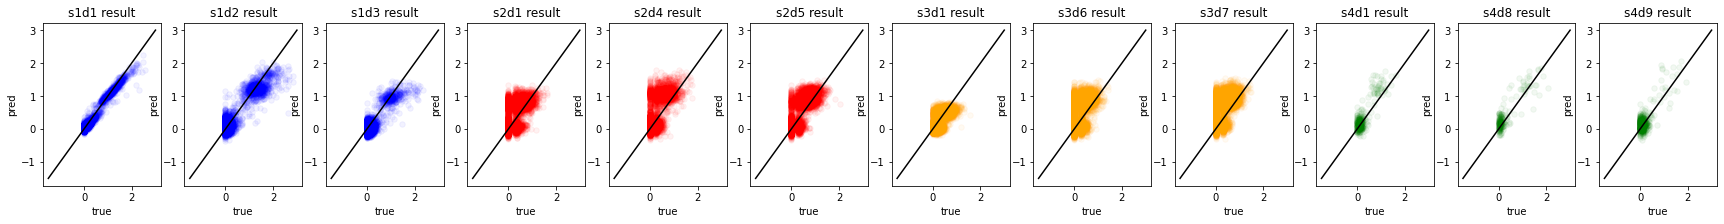

Epoch  44100 s1d1:  0.06819467 s1d2:  0.44837177 s1d3:  0.39711747 s2d1: 0.4445364 s2d4: 0.64777714 s2d5: 0.46505502 s3d1: 0.5024468 s3d6: 0.62808114 s3d7: 0.56419814 s4d1: 0.5579268 s4d8: 0.53294384 s4d9: 0.61424947
Epoch  44200 s1d1:  0.067930534 s1d2:  0.44925252 s1d3:  0.39681724 s2d1: 0.4451066 s2d4: 0.64952546 s2d5: 0.46564394 s3d1: 0.50189185 s3d6: 0.6291769 s3d7: 0.5654639 s4d1: 0.5593209 s4d8: 0.5341495 s4d9: 0.6155051
Epoch  44300 s1d1:  0.068030044 s1d2:  0.4484301 s1d3:  0.39703304 s2d1: 0.4447259 s2d4: 0.6479114 s2d5: 0.46525353 s3d1: 0.50242287 s3d6: 0.62853 s3d7: 0.5645131 s4d1: 0.55821615 s4d8: 0.532873 s4d9: 0.61445534
Epoch  44400 s1d1:  0.06799011 s1d2:  0.44831112 s1d3:  0.39742726 s2d1: 0.44448736 s2d4: 0.64801294 s2d5: 0.46500236 s3d1: 0.50223714 s3d6: 0.6282302 s3d7: 0.5644598 s4d1: 0.55793715 s4d8: 0.53270066 s4d9: 0.61398816
Epoch  44500 s1d1:  0.0678316 s1d2:  0.44823563 s1d3:  0.39715973 s2d1: 0.44439444 s2d4: 0.6479034 s2d5: 0.464906 s3d1: 0.502059 s3d6: 0.6

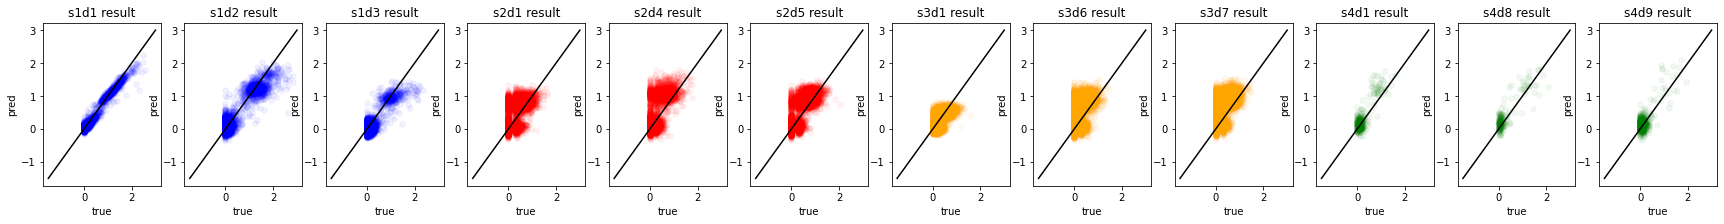

Epoch  45100 s1d1:  0.067195736 s1d2:  0.4486361 s1d3:  0.39708677 s2d1: 0.44488066 s2d4: 0.648711 s2d5: 0.46537852 s3d1: 0.50208294 s3d6: 0.6288318 s3d7: 0.56493664 s4d1: 0.558694 s4d8: 0.5334208 s4d9: 0.6149354
Epoch  45200 s1d1:  0.06709136 s1d2:  0.4489931 s1d3:  0.39720368 s2d1: 0.4449951 s2d4: 0.64903927 s2d5: 0.4656336 s3d1: 0.50179625 s3d6: 0.6292149 s3d7: 0.5657194 s4d1: 0.5589428 s4d8: 0.53394955 s4d9: 0.61508167
Epoch  45300 s1d1:  0.06707027 s1d2:  0.44849733 s1d3:  0.3975026 s2d1: 0.44452062 s2d4: 0.6484064 s2d5: 0.4651092 s3d1: 0.50179416 s3d6: 0.62831193 s3d7: 0.5647427 s4d1: 0.5582323 s4d8: 0.53307694 s4d9: 0.6142873
Epoch  45400 s1d1:  0.06673071 s1d2:  0.44937223 s1d3:  0.39664182 s2d1: 0.44548172 s2d4: 0.6500841 s2d5: 0.4660677 s3d1: 0.5017836 s3d6: 0.6298897 s3d7: 0.5659253 s4d1: 0.56030405 s4d8: 0.5348086 s4d9: 0.61649585
Epoch  45500 s1d1:  0.06693306 s1d2:  0.4483102 s1d3:  0.39740118 s2d1: 0.44442874 s2d4: 0.6480587 s2d5: 0.4649742 s3d1: 0.5017803 s3d6: 0.628086

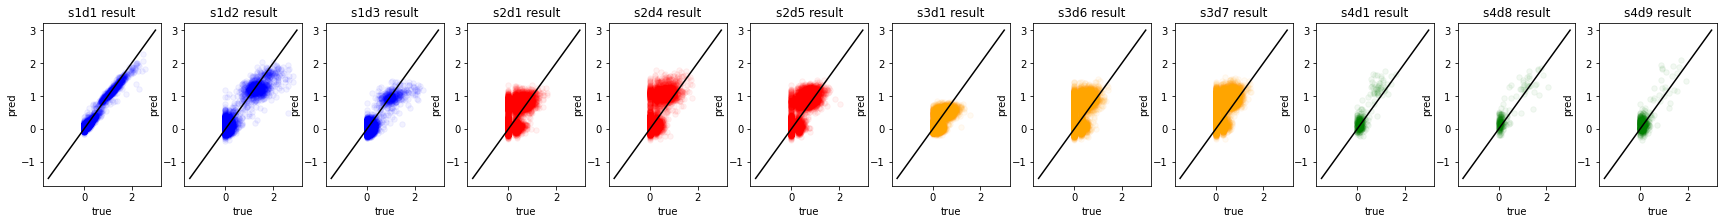

Epoch  46100 s1d1:  0.06639293 s1d2:  0.44834659 s1d3:  0.3977264 s2d1: 0.4443363 s2d4: 0.64795125 s2d5: 0.46492824 s3d1: 0.50176376 s3d6: 0.6280194 s3d7: 0.56447077 s4d1: 0.55799663 s4d8: 0.5328623 s4d9: 0.61381006
Epoch  46200 s1d1:  0.0662543 s1d2:  0.44875193 s1d3:  0.39750224 s2d1: 0.44482303 s2d4: 0.64874756 s2d5: 0.46547198 s3d1: 0.50187826 s3d6: 0.628916 s3d7: 0.5652305 s4d1: 0.5589123 s4d8: 0.5334381 s4d9: 0.614784
Epoch  46300 s1d1:  0.06621775 s1d2:  0.44864145 s1d3:  0.3976375 s2d1: 0.44456255 s2d4: 0.6481857 s2d5: 0.46528593 s3d1: 0.50181884 s3d6: 0.6284033 s3d7: 0.5647217 s4d1: 0.558776 s4d8: 0.5333968 s4d9: 0.61455005
Epoch  46400 s1d1:  0.06612661 s1d2:  0.4484794 s1d3:  0.39773336 s2d1: 0.44430417 s2d4: 0.64811677 s2d5: 0.4650271 s3d1: 0.5017708 s3d6: 0.6282681 s3d7: 0.5648013 s4d1: 0.5583667 s4d8: 0.53319985 s4d9: 0.61422473
Epoch  46500 s1d1:  0.065844275 s1d2:  0.4491869 s1d3:  0.3973401 s2d1: 0.44493955 s2d4: 0.6494026 s2d5: 0.46561947 s3d1: 0.501424 s3d6: 0.629129

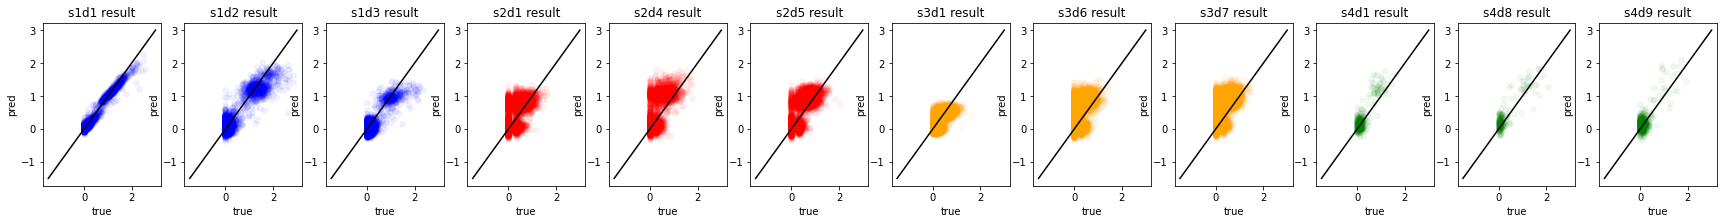

Epoch  47100 s1d1:  0.06540605 s1d2:  0.44898686 s1d3:  0.39762408 s2d1: 0.44494653 s2d4: 0.6493063 s2d5: 0.46556446 s3d1: 0.50120807 s3d6: 0.62900895 s3d7: 0.56560695 s4d1: 0.55916435 s4d8: 0.5340994 s4d9: 0.61517483
Epoch  47200 s1d1:  0.06525039 s1d2:  0.44911316 s1d3:  0.39754015 s2d1: 0.44481295 s2d4: 0.6495775 s2d5: 0.46549562 s3d1: 0.5011885 s3d6: 0.6290291 s3d7: 0.56566066 s4d1: 0.5594163 s4d8: 0.53439116 s4d9: 0.61549675
Epoch  47300 s1d1:  0.065166324 s1d2:  0.44899806 s1d3:  0.39750332 s2d1: 0.44487146 s2d4: 0.64936393 s2d5: 0.46561882 s3d1: 0.5013636 s3d6: 0.62902135 s3d7: 0.56548876 s4d1: 0.5596672 s4d8: 0.53445625 s4d9: 0.6156749
Epoch  47400 s1d1:  0.06515424 s1d2:  0.44891036 s1d3:  0.39760664 s2d1: 0.44471544 s2d4: 0.64888585 s2d5: 0.4655204 s3d1: 0.5013138 s3d6: 0.6287916 s3d7: 0.56521255 s4d1: 0.5594439 s4d8: 0.53445756 s4d9: 0.6154081
Epoch  47500 s1d1:  0.06516432 s1d2:  0.44881654 s1d3:  0.39785707 s2d1: 0.44457182 s2d4: 0.64873576 s2d5: 0.46525306 s3d1: 0.5014795

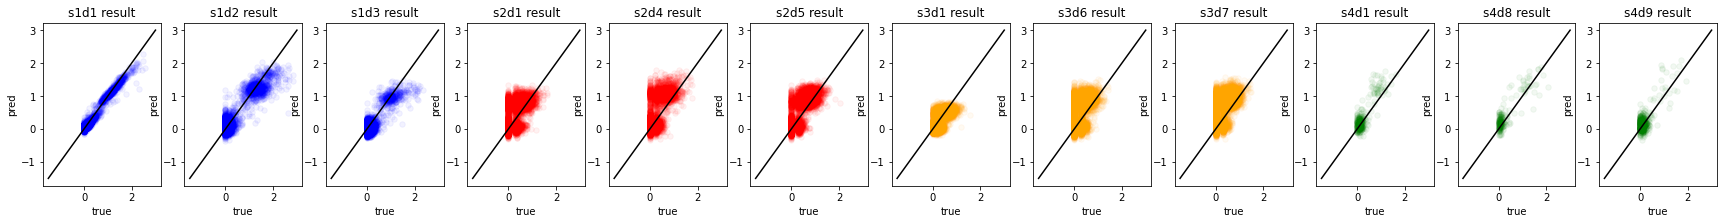

Epoch  48100 s1d1:  0.064589076 s1d2:  0.44912443 s1d3:  0.39761594 s2d1: 0.44481343 s2d4: 0.6490885 s2d5: 0.46566713 s3d1: 0.50134426 s3d6: 0.6291207 s3d7: 0.5655775 s4d1: 0.559846 s4d8: 0.53449816 s4d9: 0.6158543
Epoch  48200 s1d1:  0.06441759 s1d2:  0.44906378 s1d3:  0.3974984 s2d1: 0.4448682 s2d4: 0.64961636 s2d5: 0.4655412 s3d1: 0.50095755 s3d6: 0.6291694 s3d7: 0.5656777 s4d1: 0.5598271 s4d8: 0.53495026 s4d9: 0.61604315
Epoch  48300 s1d1:  0.064444706 s1d2:  0.44894254 s1d3:  0.3975221 s2d1: 0.4449622 s2d4: 0.6492307 s2d5: 0.4658087 s3d1: 0.5011708 s3d6: 0.62911767 s3d7: 0.5654735 s4d1: 0.56005776 s4d8: 0.53482395 s4d9: 0.61615324
Epoch  48400 s1d1:  0.064320154 s1d2:  0.4490072 s1d3:  0.39774406 s2d1: 0.44493565 s2d4: 0.6494407 s2d5: 0.46567512 s3d1: 0.5011116 s3d6: 0.6292541 s3d7: 0.5658067 s4d1: 0.55964714 s4d8: 0.5345318 s4d9: 0.61557555
Epoch  48500 s1d1:  0.06416088 s1d2:  0.4494566 s1d3:  0.39746585 s2d1: 0.44527867 s2d4: 0.64991736 s2d5: 0.46609297 s3d1: 0.5009598 s3d6: 0.

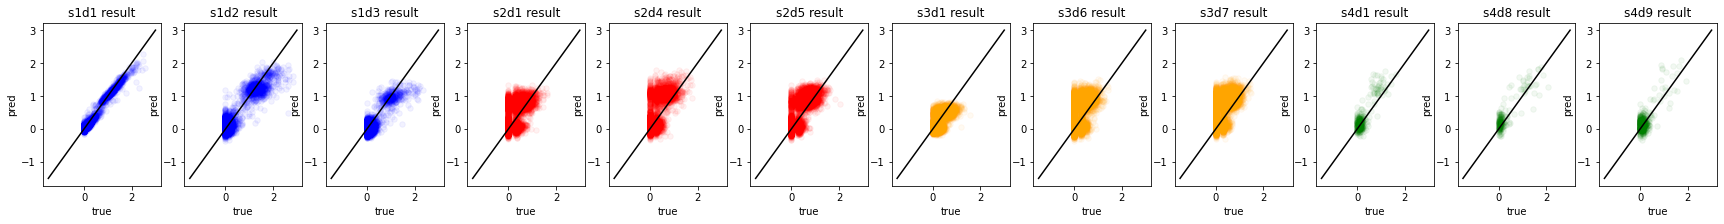

Epoch  49100 s1d1:  0.063497834 s1d2:  0.4499228 s1d3:  0.39738163 s2d1: 0.44570935 s2d4: 0.65140754 s2d5: 0.46650454 s3d1: 0.5005164 s3d6: 0.6304071 s3d7: 0.56701314 s4d1: 0.56149197 s4d8: 0.53619385 s4d9: 0.61766565
Epoch  49200 s1d1:  0.06382471 s1d2:  0.44867304 s1d3:  0.39827564 s2d1: 0.4444017 s2d4: 0.64894944 s2d5: 0.46522182 s3d1: 0.50074285 s3d6: 0.62858063 s3d7: 0.56552 s4d1: 0.558688 s4d8: 0.53377694 s4d9: 0.6146113
Epoch  49300 s1d1:  0.06374807 s1d2:  0.4485185 s1d3:  0.3983326 s2d1: 0.44422925 s2d4: 0.6485862 s2d5: 0.46503553 s3d1: 0.500723 s3d6: 0.62805855 s3d7: 0.56461006 s4d1: 0.55875015 s4d8: 0.53359383 s4d9: 0.61442876
Epoch  49400 s1d1:  0.06366415 s1d2:  0.44873312 s1d3:  0.39799345 s2d1: 0.4448192 s2d4: 0.6491301 s2d5: 0.4656539 s3d1: 0.500866 s3d6: 0.6289088 s3d7: 0.5654023 s4d1: 0.55956644 s4d8: 0.53438413 s4d9: 0.6154075
Epoch  49500 s1d1:  0.063550755 s1d2:  0.44893163 s1d3:  0.3979441 s2d1: 0.4448871 s2d4: 0.6491157 s2d5: 0.4658286 s3d1: 0.5008472 s3d6: 0.629

NameError: name 'train_pred' is not defined

In [60]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
s1d1_pred_np, s1d2_pred_np, s1d3_pred_np, s2d1_pred_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)